In [1]:
from cvxpy import *
import numpy as np
import matplotlib.pyplot as plt
import ecos

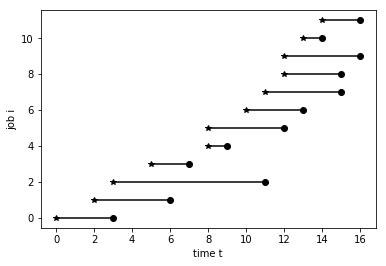

In [2]:
# Task statement
n = 12  # number of jobs.
T = 16  # number of time periods.

Smin = 1.0  # min processor speed.
Smax = 4.0  # max processor speed.
R = 1.0     # max slew rate.

# Parameters in power/speed model.
alpha = 1.0
beta = 1.0
gamma = 1.0

# Job arrival times and deadlines.
A = np.matrix('0; 2;  3; 5; 8;  8; 10; 11; 12; 12; 13; 14')
D = np.matrix('2; 5; 10; 6; 8; 11; 12; 14; 14; 15; 13; 15')

# Total work for each job.
W = np.matrix('2; 4; 10; 2; 3; 2; 3; 2; 3; 4; 1; 4')

# Plot showing job availability times & deadlines.
plt.plot(A,range(n),'k*')
plt.plot(D+1,range(n),'ko')
for i in range(n):
    plt.plot(np.array([A[i,0],D[i,0]+1]),np.array([i,i]),'k-')
plt.xlabel('time t'); plt.ylabel('job i')
plt.show()

In [3]:
def init(type='variable'):
    """
    Prepare data for experiment.
    
    Parameters:
        type: str
            'int' for integer programming
            'variable' for programming with real values in obejective

    Return:
        objective: objective function
        constraints: constraints
        x: array of velocities
        V: velocity distribution for tasks
    """
    V = None
    if type == 'int':
        V = Int(T,n) # the velocity distribution for tasks
    else:
        V = Variable(T,n)
    x = sum_entries(V, 1)# array of velocities

    #optimization portfolio 
    # We  decided to use SOCP methods to solve our problem, because this problem is more general
    # So we need reduce our objective function to canonical for SOCP form
    if gamma > 0:
        #objective function
        objective = Minimize(sum(alpha+beta*x+gamma*square(x)))

        #constraints
        end = x.size[0]    
        constraints = [
            x >= Smin,
            x <= Smax,
            abs(x[2:end]-x[1:end-1])<=R
            ]

        for i in range(T):
            for j in range(n):
                constraints += [V[i,j] >= 0]

        for i in range(n):
            for t in range(int(A[i])):
                constraints += [V[t,i] == 0]
            for t in range(int(D[i])+1, T-1):
                constraints += [V[t,i] == 0]


        constraints += [sum_entries(V, 0) >= W.T]
    else:
        #objective function
        objective = Maximize(sum(-alpha-beta*x-gamma*square(x)))

        #constraints
        end = x.size[0]    
        constraints = [
            x >= Smin,
            x <= Smax,
            abs(x[2:end]-x[1:end-1])<=R
            ]

        for i in range(T):
            for j in range(n):
                constraints += [V[i,j] >= 0]

        for i in range(n):
            for t in range(int(A[i])):
                constraints += [V[t,i] == 0]
            for t in range(int(D[i])+1, T-1):
                constraints += [V[t,i] == 0]
    return objective, constraints,x,V

In [4]:
def runECOS(verbose=False):
    """
    Run ECOS with standart parameters for solve our problem
    
    Parameters:
        verbose: bool
            verbose parameter for cvxpy.solve
    
    Return:
        x: array of velocities
        V: velocity distribution for tasks
    """
    objective, constraints,x,V = init('variable')
    prob = Problem(objective, constraints)
    prob.solve(solver='ECOS', verbose=verbose)
    return x, V

In [5]:
x,V = runECOS(True)


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.244e+01  -2.686e+00  +1e+03  6e-01  8e-01  1e+00  4e+00    ---    ---    1  1  - |  -  - 
 1  +7.082e+01  +6.018e+01  +5e+02  2e-01  2e-01  1e+00  2e+00  0.7430  2e-01   1  1  2 |  0  0
 2  +9.251e+01  +8.807e+01  +2e+02  1e-01  7e-02  9e-01  8e-01  0.6926  2e-01   1  1  1 |  0  0
 3  +1.024e+02  +9.777e+01  +2e+02  2e-01  7e-02  1e+00  5e-01  0.7789  6e-01   2  2  2 |  0  0
 4  +1.254e+02  +1.239e+02  +5e+01  5e-02  2e-02  3e-01  2e-01  0.9890  3e-01   2  2  1 |  0  0
 5  +1.398e+02  +1.394e+02  +1e+01  1e-02  5e-03  9e-02  4e-02  0.8028  5e-02   2  2  2 |  0  0
 6  +1.431e+02  +1.429e+02  +5e+00  6e-03  2e-03  4e-02  2e-02  0.8299  3e-01   2  2  2 |  0  0
 7  +1.446e+02  +1.445e+02  +2e+00  3e-03  1e-03  2e-02  8e-03  0.7934  3e-01   2  1  1 |  0  0
 8  +1.460e+02  +1.460e+02  +2e-01  3e-04  1e-

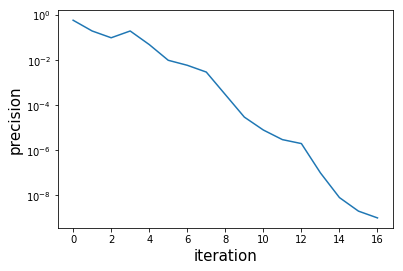

In [6]:
pres = [6e-01,2e-01,1e-01,2e-01,5e-02,1e-02,6e-03,3e-03,3e-04,3e-05,8e-06,3e-06,2e-06,1e-07,8e-09,2e-09,1e-09]
steps = [i for i in range(17)]
plt.semilogy(steps, pres)
plt.xlabel('iteration', fontsize=15)
plt.ylabel('precision', fontsize=15)
plt.show()

As we can see, solver need 16 iteration to resolve this problem with 1e-9 precision

In [7]:
# extract data from cvxpy variables
x = np.array(x.value)
x = x.squeeze()
theta = V.value/np.outer(x,np.ones(n)) # x_t distribution over avaliable tasks
bar = np.multiply(np.outer(x,np.ones(n)), theta)
bar = np.array(bar)

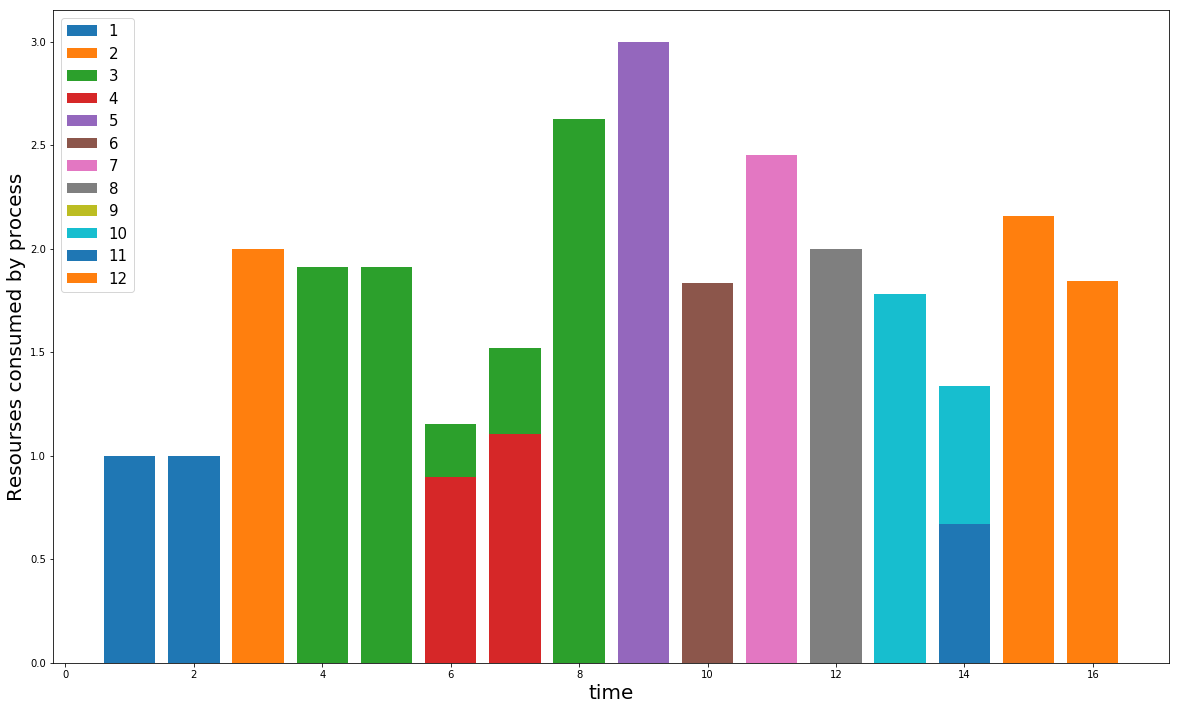

In [8]:
# Velocity distribution of each process
plt.figure(figsize=(20,12))
for i in range(n):
    plt.bar(np.arange(1,17),bar[:,i], label=i+1)
plt.xlabel('time', fontsize=20)
plt.ylabel('Resourses consumed by process', fontsize=20)
plt.legend(fontsize=15)
plt.show()

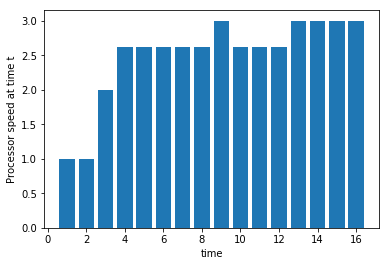

In [9]:
# Velocity distribution
plt.bar(np.arange(1,17),x)
plt.xlabel('time', fontsize=10)
plt.ylabel('Processor speed at time t', fontsize=10)
plt.legend(fontsize=10)
plt.show()

In [10]:
%timeit runECOS(verbose=False)

116 ms ± 6.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
def runSCS(verbose, p=1e-5):
    """
    Run SCS with standart parameters for solve our problem
    
    Parameters:
        verbose: bool
            verbose parameter for cvxpy.solve
        p: int,float
            set needed precision for our task in cvxpy.solve
    
    Return:
        x: array of velocities
        V: velocity distribution for tasks
    """
    
    objective, constraints,x,V = init('variable')
    prob = Problem(objective, constraints)
    prob.solve(solver='SCS', verbose=verbose, eps=p)
    return x,V

In [12]:
x,V = runSCS(True)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1849, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 222, constraints m = 469
Cones:	primal zero / dual free vars: 143
	linear vars: 278
	soc vars: 48, soc blks: 16
Setup time: 2.39e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 9.33e+00  5.21e+00  9.98e-01 -2.02e+02  3.38e+02  1.42e-13  3.70e-03 
   100| 2.78e-03  2.73e-03  6.28e-05  1.46e+02  1.46e+02  1.43e-14  9.68e-03 
   200| 6.49e-04  2.28e-04  1.72e-06  1.46e+02  1.46e+02  1.44e-14  1.47e-02

In [13]:
# extract data from cvxpy variables
x = np.array(x.value)
x = x.squeeze()
theta = V.value/np.outer(x,np.ones(n)) # x_t distribution over avaliable tasks
bar = np.multiply(np.outer(x,np.ones(n)), theta)
bar = np.array(bar)

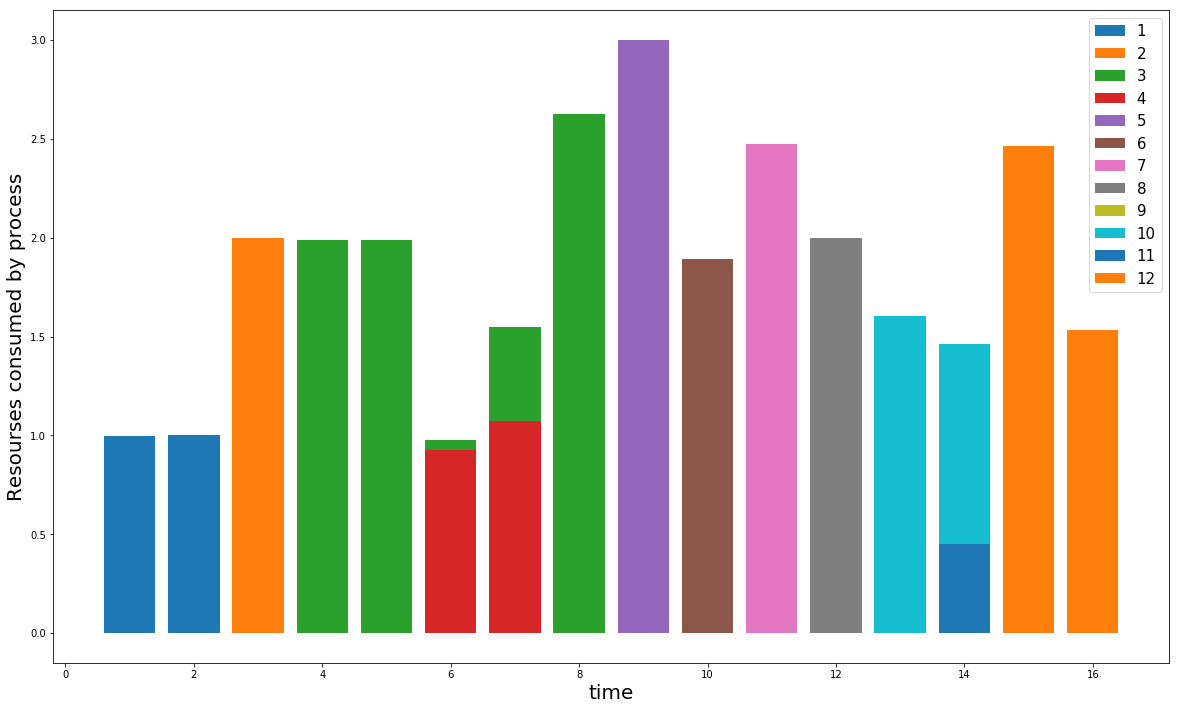

In [14]:
# Velocity distribution of each process
plt.figure(figsize=(20,12))
for i in range(n):
    plt.bar(np.arange(1,17),bar[:,i], label=i+1)
plt.xlabel('time', fontsize=20)
plt.ylabel('Resourses consumed by process', fontsize=20)
plt.legend(fontsize=15)
plt.show()

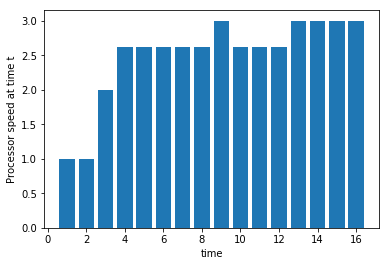

In [15]:
# Velocity distribution
plt.bar(np.arange(1,17),x)
plt.xlabel('time', fontsize=10)
plt.ylabel('Processor speed at time t', fontsize=10)
plt.legend(fontsize=10)
plt.show()

In [16]:
pres = [6e-01,2e-01,1e-01,2e-01,5e-02,1e-02,6e-03,3e-03,3e-04,3e-05,8e-06,3e-06,2e-06,1e-07,8e-09,2e-09,1e-09]
for p in pres:
    runSCS(verbose=True, p=p)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1849, CG tol ~ 1/iter^(2.00)
eps = 6.00e-01, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 222, constraints m = 469
Cones:	primal zero / dual free vars: 143
	linear vars: 278
	soc vars: 48, soc blks: 16
Setup time: 2.78e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 9.33e+00  5.21e+00  9.98e-01 -2.02e+02  3.38e+02  1.42e-13  4.11e-03 
    20| 4.43e-02  6.93e-02  8.10e-03  1.40e+02  1.42e+02  1.33e-14  6.06e-03 
----------------------------------------------------------------------------

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1849, CG tol ~ 1/iter^(2.00)
eps = 3.00e-04, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 222, constraints m = 469
Cones:	primal zero / dual free vars: 143
	linear vars: 278
	soc vars: 48, soc blks: 16
Setup time: 3.76e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 9.33e+00  5.21e+00  9.98e-01 -2.02e+02  3.38e+02  1.42e-13  3.64e-03 
   100| 2.78e-03  2.73e-03  6.28e-05  1.46e+02  1.46e+02  1.43e-14  9.44e-03 
   200| 6.49e-04  2.28e-04  1.72e-06  1.46e+02  1.46e+02  1.44e-14  1.77e-02

   900| 9.68e-08  6.86e-08  2.09e-09  1.46e+02  1.46e+02  1.44e-14  1.56e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.56e-01s
	Lin-sys: avg # CG iterations: 5.00, avg solve time: 3.31e-05s
	Cones: avg projection time: 4.16e-07s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.1512e-15, dist(y, K*) = 8.8818e-16, s'y/|s||y| = 8.2044e-18
|Ax + s - b|_2 / (1 + |b|_2) = 9.6783e-08
|A'y + c|_2 / (1 + |c|_2) = 6.8601e-08
|c'x + b'y| / (1 + |c'x| + |b'y|) = 2.0926e-09
----------------------------------------------------------------------------
c'x = 146.1250, -b'y = 146.1250
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1849, CG t

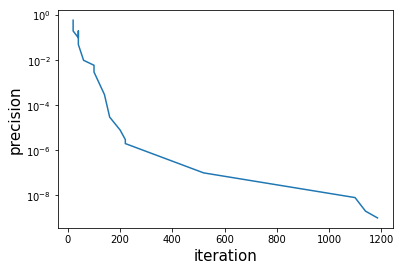

In [17]:
iters = [20,20,40,40,40,60,100,100,140,160,200,220,220,520,1100,1140,1186]
plt.semilogy(iters, pres)
plt.xlabel('iteration', fontsize=15)
plt.ylabel('precision', fontsize=15)
plt.show()

In [18]:
%timeit runSCS(verbose=False,p=1e-5)

143 ms ± 15.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
def runECOS_BB(verbose):  
    """
    Run ECOS_BB with standart parameters for solve our problem
    
    Parameters:
        verbose: bool
            verbose parameter for cvxpy.solve
    
    Return:
        x: array of velocities
        V: velocity distribution for tasks
    """
    
    objective, constraints,x,V = init('int')
    prob = Problem(objective, constraints)
    prob.solve(solver='ECOS_BB', verbose=verbose)
    return x,V

In [ ]:
x,V = runECOS_BB(True)


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +2.716e+01  -4.755e+09  +5e+09  4e-07  7e-01  1e+00  7e+06    ---    ---    1  1  - |  -  - 
 1  +1.724e+02  -4.754e+09  +5e+09  2e-07  3e-01  1e+01  7e+06  0.0000  4e-02   1  1  1 |  0  0
 2  +2.781e+02  -4.754e+09  +5e+09  3e-07  1e-01  4e+01  7e+06  0.0002  2e-02   1  1  1 |  0  0
 3  +7.586e+02  -4.751e+09  +5e+09  2e-07  5e-02  1e+02  7e+06  0.0006  2e-02   1  1  1 |  0  0
 4  +2.156e+03  -3.176e+09  +3e+09  2e-07  1e-02  4e+02  5e+06  0.3315  1e-04   1  1  1 |  0  0
 5  +4.716e+03  -3.162e+09  +3e+09  2e-07  4e-03  7e+02  5e+06  0.0045  2e-02   1  1  1 |  0  0
 6  +3.587e+03  -5.870e+08  +6e+08  4e-07  4e-04  5e+02  9e+05  0.8145  1e-04   1  1  1 |  0  0
 7  +9.161e+02  -6.508e+06  +7e+06  2e-06  3e-06  9e+01  1e+04  0.9890  1e-04   1  1  1 |  0  0
 8  +2.827e+02  -3.130e+05  +3e+05  6e-06  1e-

96  +1.461e+02  +1.461e+02  +6e-03  3e-10  5e-11  9e-09  8e-06  0.1263  6e-01   1  1  1 |  0  0
97  +1.461e+02  +1.461e+02  +3e-03  8e-11  1e-11  5e-10  4e-06  0.9770  2e-02   1  1  1 |  0  0
98  +1.461e+02  +1.461e+02  +1e-02  8e-11  1e-11  3e-09  2e-05  0.9890  2e-01   1  1  1 |  0  0
99  +1.461e+02  +1.461e+02  +1e-03  1e-10  3e-12  5e-09  2e-06  0.9890  1e-01   1  1  1 |  0  0
100  +1.461e+02  +1.461e+02  +5e-03  7e-10  8e-11  3e-09  8e-06  0.1781  8e-01   1  1  1 |  0  0
Maximum number of iterations reached, recovering best iterate (30) and stopping.

Close to OPTIMAL (within feastol=3.2e-11, reltol=1.7e-07, abstol=2.5e-05).
Runtime: 0.025525 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.416e+01  -8.068e-01  +2e+03  6e-01  7e-01  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  +8.516e+01  +6.868e+01  +9e+02  4e-01  3e-01  2e

No further progress possible, recovering best iterate (50) and stopping.
Close to OPTIMAL (within feastol=3.6e-11, reltol=1.1e-06, abstol=1.6e-04).
Runtime: 0.043361 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.423e+01  -7.375e-01  +2e+03  6e-01  7e-01  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  +8.621e+01  +7.028e+01  +9e+02  4e-01  3e-01  2e+00  1e+00  0.7608  3e-01   1  1  2 |  0  0
 2  +1.071e+02  +1.019e+02  +3e+02  1e-01  8e-02  9e-01  5e-01  0.6889  6e-02   1  1  1 |  0  0
 3  +1.081e+02  +1.023e+02  +3e+02  2e-01  9e-02  1e+00  4e-01  0.1713  8e-01   2  2  2 |  0  0
 4  +1.287e+02  +1.259e+02  +1e+02  1e-01  4e-02  7e-01  2e-01  0.7345  2e-01   2  2  1 |  0  0
 5  +1.505e+02  +1.499e+02  +3e+01  3e-02  1e-02  2e-01  4e-02  0.8728  9e-0

99  +1.461e+02  +1.461e+02  +4e-03  2e-10  2e-11  5e-09  6e-06  0.4282  4e-01   1  1  1 |  0  0
100  +1.461e+02  +1.461e+02  +6e-03  3e-10  2e-11  2e-08  8e-06  0.9798  6e-01   1  1  1 |  0  0
Maximum number of iterations reached, recovering best iterate (53) and stopping.

Close to OPTIMAL (within feastol=1.9e-10, reltol=8.0e-07, abstol=1.2e-04).
Runtime: 0.223940 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.411e+01  -8.603e-01  +2e+03  6e-01  7e-01  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  +8.748e+01  +7.321e+01  +8e+02  3e-01  2e-01  2e+00  1e+00  0.7971  2e-01   1  1  2 |  0  0
 2  +1.063e+02  +1.020e+02  +3e+02  1e-01  7e-02  8e-01  4e-01  0.7173  7e-02   1  1  1 |  0  0
 3  +1.078e+02  +1.030e+02  +3e+02  1e-01  7e-02  9e-01  4e-01  0.2076  8e-01   2  2  2 |  0  0
 4  +1.250e+02  +1.224e+02  +1e+02  9e-02  4e-02  6e

36  +1.463e+02  +1.463e+02  +1e-03  3e-09  5e-10  8e-09  2e-06  0.9890  2e-01   1  1  1 |  0  0
37  +1.463e+02  +1.463e+02  +8e-04  1e-09  2e-10  2e-09  1e-06  0.9890  4e-02   1  1  1 |  0  0
38  +1.463e+02  +1.463e+02  +1e-03  4e-10  1e-10  5e-09  2e-06  0.1863  3e-01   1  1  1 |  0  0
39  +1.463e+02  +1.463e+02  +3e-04  3e-10  4e-11  4e-09  5e-07  0.9890  3e-02   1  1  1 |  0  0
40  +1.463e+02  +1.463e+02  +5e-04  3e-09  2e-10  5e-09  7e-07  0.0288  9e-01   1  1  1 |  0  0
41  +1.463e+02  +1.463e+02  +4e-03  3e-09  5e-10  2e-08  5e-06  0.8809  6e-01   1  1  1 |  0  0
42  +1.463e+02  +1.463e+02  +2e-04  5e-10  4e-11  9e-09  3e-07  0.9890  5e-02   1  1  1 |  0  0
43  +1.463e+02  +1.463e+02  +1e-03  7e-10  1e-10  8e-09  2e-06  0.0385  8e-01   1  1  1 |  0  0
44  +1.463e+02  +1.463e+02  +2e-03  2e-09  3e-10  2e-08  3e-06  0.9890  4e-01   1  1  1 |  0  0
45  +1.463e+02  +1.463e+02  +1e-03  8e-10  1e-10  3e-09  2e-06  0.8701  5e-02   1  1  1 |  0  0
46  +1.463e+02  +1.463e+02  +4e-03  9e-1

 0  +1.429e+05  -4.705e+09  +7e+09  2e-01  7e-01  1e+00  1e+07    ---    ---    1  1  - |  -  - 
 1  +8.358e+06  -1.479e+09  +2e+09  5e-02  2e-01  2e+06  4e+06  0.8883  3e-01   0  0  1 |  0  0
 2  +6.981e+04  -3.271e+07  +6e+07  1e-03  4e-03  8e+04  9e+04  0.9869  1e-02   0  0  0 |  0  0
 3  +8.485e+02  -3.619e+05  +7e+05  1e-05  6e-05  9e+02  1e+03  0.9890  1e-04   0  0  0 |  0  0
 4  +5.531e+01  -6.871e+03  +1e+04  3e-07  1e-06  2e+01  2e+01  0.9810  1e-04   0  0  0 |  0  0
 5  +5.659e+01  -1.476e+03  +3e+03  6e-08  2e-07  4e+00  4e+00  0.8025  3e-02   1  1  1 |  0  0
 6  +7.434e+01  -1.337e+03  +3e+03  1e-07  2e-07  3e+00  4e+00  0.2922  6e-01   1  1  1 |  0  0
 7  +1.096e+02  -4.069e+02  +9e+02  7e-08  5e-08  1e+00  1e+00  0.7598  2e-01   1  1  1 |  0  0
 8  +1.259e+02  -1.106e+02  +4e+02  4e-08  2e-08  6e-01  6e-01  0.6387  1e-01   1  1  1 |  0  0
 9  +1.290e+02  -8.776e+01  +4e+02  6e-08  2e-08  5e-01  5e-01  0.3926  7e-01   1  1  1 |  0  0
10  +1.429e+02  +1.012e+02  +7e+01  3e-

Runtime: 0.003003 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -9.619e+05  -4.706e+09  +7e+09  2e-01  7e-01  1e+00  1e+07    ---    ---    1  1  - |  -  - 
 1  +8.002e+06  -1.364e+09  +2e+09  5e-02  2e-01  2e+06  3e+06  0.8786  2e-01   0  0  1 |  0  0
 2  +6.183e+04  -2.981e+07  +5e+07  1e-03  4e-03  7e+04  8e+04  0.9870  1e-02   1  0  0 |  0  0
 3  +7.583e+02  -3.300e+05  +6e+05  1e-05  5e-05  8e+02  9e+02  0.9890  1e-04   0  0  0 |  0  0
 4  +5.435e+01  -6.888e+03  +1e+04  2e-07  1e-06  2e+01  2e+01  0.9791  1e-04   0  0  0 |  0  0
 5  +5.872e+01  -1.664e+03  +3e+03  7e-08  3e-07  4e+00  5e+00  0.7999  6e-02   1  1  1 |  0  0
 6  +7.349e+01  -1.531e+03  +3e+03  1e-07  2e-07  4e+00  4e+00  0.2641  6e-01   1  1  1 |  0  0
 7  +1.033e+02  -6.152e+02  +1e+03  8e-08  6e-08  2e+00  2e+00  0.6882  2e-01   1  1  1 |  0  0
 8  +1.223e+02  -1

 9  +1.620e+02  +1.620e+02  +6e-03  7e-06  2e-06  5e-05  8e-06  0.9197  2e-02   2  1  1 |  0  0
10  +1.620e+02  +1.620e+02  +2e-04  3e-07  1e-07  2e-06  3e-07  0.9619  3e-03   2  1  1 |  0  0
11  +1.620e+02  +1.620e+02  +1e-05  1e-08  5e-09  9e-08  2e-08  0.9616  8e-03   2  1  1 |  0  0
12  +1.620e+02  +1.620e+02  +2e-07  2e-10  8e-11  2e-09  3e-10  0.9831  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=2.2e-10, reltol=1.1e-09, abstol=1.8e-07).
Runtime: 0.004182 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.252e+06  -4.694e+09  +7e+09  1e-01  7e-01  1e+00  1e+07    ---    ---    1  1  - |  -  - 
 1  +9.753e+06  -1.888e+09  +3e+09  6e-02  3e-01  2e+06  4e+06  0.8198  3e-01   0  0  1 |  0  0
 2  +1.475e+05  -4.944e+07  +8e+07  2e-03  6e-03  1e+05  1e+05  0.9861  1e-02   1  0  0 |  0  0
 3  +1.731e+03  -5.468e+05  +9e+05  2e-05  8e-0


Close to OPTIMAL (within feastol=2.7e-11, reltol=7.6e-07, abstol=1.1e-04).
Runtime: 0.145479 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.415e+01  -8.143e-01  +2e+03  6e-01  7e-01  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  +8.706e+01  +7.229e+01  +8e+02  4e-01  3e-01  2e+00  1e+00  0.7803  2e-01   1  1  2 |  0  0
 2  +1.087e+02  +1.045e+02  +3e+02  1e-01  7e-02  8e-01  4e-01  0.7383  6e-02   1  1  1 |  0  0
 3  +1.111e+02  +1.049e+02  +2e+02  2e-01  7e-02  2e+00  3e-01  0.4487  7e-01   2  2  2 |  0  0
 4  +1.721e+02  +1.700e+02  +5e+01  2e-01  3e-02  3e+00  7e-02  0.8758  1e-01   2  2  1 |  0  0
 5  +7.879e+02  +8.232e+02  +4e+00  3e-01  3e-02  4e+01  6e-03  0.9890  7e-02   2  2  2 |  0  0
 6  +5.171e+04  +5.481e+04  +5e-02  3e-01  3e-02  3e+03  8e-05  0.9866  1e-04   2  2  2 |  0  0
 7  +2.556e+06  +2.705e+06  +1e-03  3e

68  +1.463e+02  +1.463e+02  +1e-03  1e-09  2e-10  2e-08  2e-06  0.6608  3e-01   1  1  1 |  0  0
69  +1.463e+02  +1.463e+02  +3e-03  1e-09  2e-10  1e-08  4e-06  0.9890  4e-01   1  1  1 |  0  0
70  +1.463e+02  +1.463e+02  +3e-04  1e-10  3e-11  1e-09  5e-07  0.9087  6e-03   1  1  1 |  0  0
71  +1.463e+02  +1.463e+02  +5e-03  3e-10  7e-11  2e-09  7e-06  0.1795  7e-01   1  1  1 |  0  0
72  +1.463e+02  +1.463e+02  +3e-04  2e-10  1e-11  6e-09  4e-07  0.9890  5e-02   1  1  1 |  0  0
73  +1.463e+02  +1.463e+02  +2e-03  4e-10  6e-11  5e-09  3e-06  0.0392  8e-01   1  1  1 |  0  0
74  +1.463e+02  +1.463e+02  +2e-03  2e-10  2e-11  7e-09  3e-06  0.0876  4e-01   1  1  1 |  0  0
75  +1.463e+02  +1.463e+02  +3e-03  3e-09  3e-11  2e-08  4e-06  0.4156  8e-01   1  1  1 |  0  0
76  +1.463e+02  +1.463e+02  +3e-03  1e-09  6e-11  3e-08  4e-06  0.9890  5e-01   1  1  1 |  0  0
77  +1.463e+02  +1.463e+02  +2e-03  6e-10  8e-11  7e-09  3e-06  0.7739  6e-02   1  1  1 |  0  0
78  +1.463e+02  +1.463e+02  +3e-03  5e-1

 1  +8.551e+06  -1.468e+09  +2e+09  5e-02  2e-01  2e+06  4e+06  0.8882  3e-01   0  0  1 |  0  0
 2  +6.663e+04  -3.315e+07  +6e+07  1e-03  4e-03  8e+04  9e+04  0.9863  1e-02   0  0  0 |  0  0
 3  +8.144e+02  -3.668e+05  +7e+05  1e-05  6e-05  9e+02  1e+03  0.9890  1e-04   0  0  0 |  0  0
 4  +5.474e+01  -6.919e+03  +1e+04  3e-07  1e-06  2e+01  2e+01  0.9811  1e-04   0  0  0 |  0  0
 5  +5.654e+01  -1.490e+03  +3e+03  7e-08  2e-07  4e+00  4e+00  0.8020  3e-02   1  1  1 |  0  0
 6  +7.456e+01  -1.348e+03  +3e+03  1e-07  2e-07  3e+00  4e+00  0.2969  6e-01   1  1  1 |  0  0
 7  +1.099e+02  -4.032e+02  +9e+02  7e-08  5e-08  1e+00  1e+00  0.7619  2e-01   1  1  1 |  0  0
 8  +1.258e+02  -1.110e+02  +4e+02  4e-08  2e-08  6e-01  6e-01  0.6255  1e-01   1  1  1 |  0  0
 9  +1.290e+02  -8.872e+01  +4e+02  6e-08  2e-08  5e-01  5e-01  0.3870  7e-01   1  1  1 |  0  0
10  +1.434e+02  +1.049e+02  +6e+01  3e-08  3e-09  9e-02  9e-02  0.9790  2e-01   1  1  1 |  0  0
11  +1.454e+02  +1.355e+02  +2e+01  2e-0

35  +1.463e+02  +1.463e+02  +9e-04  8e-09  4e-10  7e-08  1e-06  0.5454  8e-01   1  1  1 |  0  0
36  +1.463e+02  +1.463e+02  +5e-04  3e-09  3e-10  2e-08  7e-07  0.6518  1e-02   1  1  1 |  0  0
37  +1.463e+02  +1.463e+02  +2e-03  3e-09  6e-10  2e-08  3e-06  0.9890  4e-01   1  1  1 |  0  0
38  +1.463e+02  +1.463e+02  +8e-05  4e-10  2e-11  7e-09  1e-07  0.9890  3e-02   1  1  1 |  0  0
39  +1.463e+02  +1.463e+02  +1e-03  6e-10  3e-10  6e-09  1e-06  0.0393  9e-01   1  1  1 |  0  0
40  +1.463e+02  +1.463e+02  +1e-03  2e-09  3e-10  2e-08  1e-06  0.3359  4e-01   1  1  1 |  0  0
41  +1.463e+02  +1.463e+02  +1e-03  3e-09  3e-10  3e-08  2e-06  0.5083  6e-01   1  1  1 |  0  0
42  +1.463e+02  +1.463e+02  +1e-03  3e-09  2e-10  5e-08  2e-06  0.9890  4e-01   1  1  1 |  0  0
43  +1.463e+02  +1.463e+02  +8e-04  1e-09  2e-10  9e-09  1e-06  0.7962  6e-02   1  1  1 |  0  0
44  +1.463e+02  +1.463e+02  +2e-03  7e-10  9e-11  1e-08  3e-06  0.4492  2e-01   1  1  1 |  0  0
45  +1.463e+02  +1.463e+02  +7e-05  2e-1

63  +1.465e+02  +1.465e+02  +3e-04  7e-11  2e-12  1e-09  4e-07  0.9890  3e-02   1  1  1 |  0  0
64  +1.465e+02  +1.465e+02  +2e-02  1e-10  3e-11  1e-09  2e-05  0.0847  9e-01   1  1  1 |  0  0
65  +1.465e+02  +1.465e+02  +1e-02  2e-10  3e-11  3e-09  2e-05  0.1010  3e-01   1  1  1 |  0  0
66  +1.465e+02  +1.465e+02  +1e-02  4e-10  3e-11  1e-08  2e-05  0.1138  8e-01   1  1  1 |  0  0
67  +1.465e+02  +1.465e+02  +1e-02  7e-10  2e-11  3e-08  2e-05  0.3218  7e-01   1  1  1 |  0  0
68  +1.465e+02  +1.465e+02  +9e-03  8e-10  1e-11  4e-08  1e-05  0.7758  6e-01   1  1  1 |  0  0
69  +1.465e+02  +1.465e+02  +8e-03  8e-10  9e-12  4e-08  1e-05  0.1654  9e-01   1  1  1 |  0  0
70  +1.465e+02  +1.465e+02  +1e-03  1e-10  5e-12  5e-09  2e-06  0.8752  5e-03   1  1  1 |  0  0
71  +1.465e+02  +1.465e+02  +1e-02  2e-10  4e-11  4e-09  2e-05  0.3326  6e-01   1  1  1 |  0  0
72  +1.465e+02  +1.465e+02  +3e-03  3e-10  1e-11  1e-08  5e-06  0.9284  2e-01   1  1  1 |  0  0
73  +1.465e+02  +1.465e+02  +1e-02  2e-1

 8  +1.262e+02  -1.205e+02  +5e+02  7e-08  5e-08  5e-01  7e-01  0.8604  6e-01   1  1  1 |  0  0
 9  +1.419e+02  +9.542e+01  +9e+01  3e-08  8e-09  1e-01  1e-01  0.8527  5e-02   1  1  1 |  0  0
10  +1.436e+02  +1.190e+02  +4e+01  3e-08  4e-09  6e-02  7e-02  0.9356  5e-01   1  0  1 |  0  0
11  +1.461e+02  +1.430e+02  +6e+00  8e-09  7e-10  7e-03  8e-03  0.9600  9e-02   1  0  0 |  0  0
12  +1.464e+02  +1.457e+02  +1e+00  4e-09  2e-10  2e-03  2e-03  0.8557  1e-01   1  0  0 |  0  0
13  +1.465e+02  +1.461e+02  +6e-01  3e-09  1e-10  8e-04  9e-04  0.7191  2e-01   1  0  1 |  0  0
14  +1.465e+02  +1.463e+02  +3e-01  4e-09  9e-11  4e-04  5e-04  0.7496  4e-01   1  1  0 |  0  0
15  +1.465e+02  +1.465e+02  +6e-02  2e-09  6e-11  8e-05  9e-05  0.9890  2e-01   1  1  1 |  0  0
16  +1.465e+02  +1.465e+02  +8e-03  4e-10  2e-11  1e-05  1e-05  0.9102  4e-02   1  1  1 |  0  0
17  +1.465e+02  +1.465e+02  +2e-03  1e-09  2e-11  3e-06  3e-06  0.9890  3e-01   1  1  1 |  0  0
18  +1.465e+02  +1.465e+02  +5e-04  3e-1

No further progress possible, recovering best iterate (39) and stopping.
Close to OPTIMAL (within feastol=9.0e-11, reltol=8.6e-06, abstol=1.3e-03).
Runtime: 0.141122 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.363e+01  -1.336e+00  +2e+03  6e-01  7e-01  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  +8.366e+01  +6.746e+01  +9e+02  4e-01  3e-01  2e+00  1e+00  0.7508  3e-01   1  1  2 |  0  0
 2  +1.037e+02  +9.826e+01  +3e+02  2e-01  8e-02  9e-01  5e-01  0.6783  6e-02   1  1  1 |  0  0
 3  +1.043e+02  +9.813e+01  +3e+02  2e-01  9e-02  1e+00  5e-01  0.1903  8e-01   2  2  2 |  0  0
 4  +1.235e+02  +1.202e+02  +1e+02  1e-01  5e-02  9e-01  2e-01  0.7237  2e-01   2  2  1 |  0  0
 5  +1.796e+02  +1.728e+02  +6e+01  6e-01  8e-02  6e+00  9e-02  0.8386  4e-0

61  +1.463e+02  +1.463e+02  +2e-03  5e-11  1e-11  5e-10  3e-06  0.9890  2e-02   1  1  1 |  0  0
62  +1.463e+02  +1.463e+02  +7e-03  8e-11  1e-11  2e-09  1e-05  0.5863  2e-01   1  1  1 |  0  0
63  +1.463e+02  +1.463e+02  +6e-03  4e-10  1e-11  2e-08  9e-06  0.5215  6e-01   1  1  1 |  0  0
64  +1.463e+02  +1.463e+02  +6e-03  4e-10  5e-12  2e-08  8e-06  0.9890  6e-01   1  1  1 |  0  0
65  +1.463e+02  +1.463e+02  +3e-03  1e-10  2e-11  2e-09  4e-06  0.8891  2e-02   1  1  1 |  0  0
66  +1.463e+02  +1.463e+02  +9e-03  8e-11  1e-11  3e-09  1e-05  0.9890  2e-01   1  1  1 |  0  0
67  +1.463e+02  +1.463e+02  +2e-04  1e-11  3e-13  7e-10  3e-07  0.9890  1e-02   1  1  1 |  0  0
68  +1.463e+02  +1.463e+02  +2e-02  2e-11  1e-11  7e-10  4e-05  0.1059  9e-01   1  1  1 |  0  0
69  +1.463e+02  +1.463e+02  +8e-04  5e-11  5e-13  3e-09  1e-06  0.9890  2e-02   1  1  1 |  0  0
70  +1.463e+02  +1.463e+02  +1e-02  8e-11  2e-11  3e-09  2e-05  0.1876  7e-01   1  1  1 |  0  0
71  +1.463e+02  +1.463e+02  +8e-04  9e-1

31  +1.463e+02  +1.463e+02  +4e-04  4e-09  4e-10  3e-08  6e-07  0.6985  3e-02   1  1  1 |  0  0
32  +1.463e+02  +1.463e+02  +1e-03  4e-09  7e-10  2e-08  2e-06  0.6627  3e-01   1  1  1 |  0  0
33  +1.463e+02  +1.463e+02  +9e-04  4e-09  6e-10  4e-08  1e-06  0.3271  4e-01   1  1  1 |  0  0
34  +1.463e+02  +1.463e+02  +5e-04  5e-09  5e-10  5e-08  8e-07  0.9890  4e-01   1  1  1 |  0  0
35  +1.463e+02  +1.463e+02  +1e-03  4e-09  7e-10  1e-08  2e-06  0.5797  2e-01   1  1  1 |  0  0
36  +1.463e+02  +1.463e+02  +1e-03  4e-09  6e-10  3e-08  2e-06  0.3555  4e-01   1  1  1 |  0  0
37  +1.463e+02  +1.463e+02  +1e-03  4e-09  5e-10  4e-08  2e-06  0.7709  5e-01   1  1  1 |  0  0
38  +1.463e+02  +1.463e+02  +1e-03  5e-09  5e-10  5e-08  2e-06  0.2318  8e-01   1  1  1 |  0  0
39  +1.463e+02  +1.463e+02  +7e-04  2e-09  3e-10  1e-08  1e-06  0.6490  2e-02   1  1  1 |  0  0
40  +1.463e+02  +1.463e+02  +1e-03  2e-09  4e-10  1e-08  2e-06  0.3559  4e-01   1  1  1 |  0  0
41  +1.463e+02  +1.463e+02  +1e-03  3e-0

Runtime: 0.147509 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.369e+01  -1.276e+00  +2e+03  6e-01  7e-01  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  +8.623e+01  +7.193e+01  +8e+02  3e-01  2e-01  2e+00  1e+00  0.8001  3e-01   1  1  2 |  0  0
 2  +1.059e+02  +1.016e+02  +3e+02  1e-01  7e-02  8e-01  4e-01  0.7189  6e-02   1  1  1 |  0  0
 3  +1.068e+02  +1.016e+02  +2e+02  2e-01  7e-02  1e+00  4e-01  0.2546  7e-01   2  2  2 |  0  0
 4  +1.235e+02  +1.203e+02  +1e+02  1e-01  4e-02  1e+00  2e-01  0.6326  2e-01   2  2  2 |  0  0
 5  +1.719e+02  +1.673e+02  +5e+01  4e-01  5e-02  5e+00  8e-02  0.8020  3e-01   2  2  2 |  0  0
 6  +4.980e+02  +5.181e+02  +4e+00  2e-01  3e-02  3e+01  6e-03  0.9890  7e-02   2  1  1 |  0  0
 7  +2.860e+04  +3.043e+04  +6e-02  2e-01  3e-02  2e+03  9e-05  0.9865  1e-04   2  2  2 |  0  0
 8  +1.401e+06  +1

25  +1.467e+02  +1.467e+02  +1e-04  8e-09  5e-10  4e-08  2e-07  0.8561  2e-01   1  1  1 |  0  0
26  +1.467e+02  +1.467e+02  +2e-03  7e-09  1e-09  3e-08  3e-06  0.7717  5e-01   1  1  1 |  0  0
27  +1.467e+02  +1.467e+02  +1e-04  4e-09  4e-11  5e-08  2e-07  0.9890  5e-02   1  1  1 |  0  0
28  +1.467e+02  +1.467e+02  +4e-04  5e-09  8e-10  3e-08  6e-07  0.1990  5e-01   1  1  1 |  0  0
29  +1.467e+02  +1.467e+02  +5e-04  6e-09  1e-09  2e-08  7e-07  0.9890  3e-01   1  1  1 |  0  0
30  +1.467e+02  +1.467e+02  +6e-04  4e-09  8e-10  6e-09  8e-07  0.7247  9e-02   1  1  1 |  0  0
31  +1.467e+02  +1.467e+02  +9e-04  5e-09  7e-10  2e-08  1e-06  0.4057  4e-01   1  1  1 |  0  0
32  +1.467e+02  +1.467e+02  +1e-03  5e-09  7e-10  3e-08  1e-06  0.2182  6e-01   1  1  1 |  0  0
33  +1.467e+02  +1.467e+02  +1e-03  6e-09  6e-10  5e-08  1e-06  0.5795  6e-01   1  1  1 |  0  0
34  +1.467e+02  +1.467e+02  +1e-03  6e-09  6e-10  5e-08  2e-06  0.1739  6e-01   1  1  1 |  0  0
35  +1.467e+02  +1.467e+02  +7e-04  4e-0

Unreliable search direction detected, recovering best iterate (45) and stopping.

Close to OPTIMAL (within feastol=1.3e-10, reltol=6.4e-07, abstol=9.3e-05).
Runtime: 0.151809 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.401e+01  -9.551e-01  +2e+03  6e-01  7e-01  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  +8.618e+01  +7.062e+01  +9e+02  4e-01  3e-01  2e+00  1e+00  0.7681  3e-01   1  1  2 |  0  0
 2  +1.074e+02  +1.031e+02  +3e+02  1e-01  7e-02  8e-01  4e-01  0.7428  6e-02   1  1  1 |  0  0
 3  +1.104e+02  +1.036e+02  +2e+02  3e-01  7e-02  2e+00  3e-01  0.4739  7e-01   2  2  2 |  0  0
 4  +1.716e+02  +1.697e+02  +5e+01  2e-01  3e-02  3e+00  7e-02  0.9006  1e-01   2  2  1 |  0  0
 5  +1.154e+03  +1.208e+03  +3e+00  3e-01  3e-02  6e+01  4e-03  0.

47  +1.465e+02  +1.465e+02  +2e-03  1e-09  2e-10  2e-08  4e-06  0.4659  4e-01   1  1  1 |  0  0
48  +1.465e+02  +1.465e+02  +3e-03  1e-09  2e-10  2e-08  4e-06  0.9890  5e-01   1  1  1 |  0  0
49  +1.465e+02  +1.465e+02  +3e-03  1e-09  1e-10  2e-08  4e-06  0.8416  5e-01   1  1  1 |  0  0
50  +1.465e+02  +1.465e+02  +2e-03  4e-10  7e-11  4e-09  2e-06  0.7871  2e-02   1  1  1 |  0  0
51  +1.465e+02  +1.465e+02  +3e-03  4e-10  7e-11  6e-09  4e-06  0.2826  4e-01   1  1  1 |  0  0
52  +1.465e+02  +1.465e+02  +3e-03  6e-10  7e-11  1e-08  4e-06  0.3868  6e-01   1  1  1 |  0  0
53  +1.465e+02  +1.465e+02  +3e-03  7e-10  7e-11  2e-08  4e-06  0.7135  4e-01   1  1  1 |  0  0
54  +1.465e+02  +1.465e+02  +2e-03  3e-10  5e-11  4e-09  3e-06  0.8066  4e-02   1  1  1 |  0  0
55  +1.465e+02  +1.465e+02  +3e-03  5e-10  9e-11  5e-09  4e-06  0.4467  2e-01   1  1  1 |  0  0
56  +1.465e+02  +1.465e+02  +3e-03  5e-10  8e-11  1e-08  5e-06  0.4072  5e-01   1  1  1 |  0  0
57  +1.465e+02  +1.465e+02  +4e-03  6e-1

33  +1.465e+02  +1.465e+02  +1e-03  4e-09  7e-10  3e-08  1e-06  0.6162  4e-01   1  1  1 |  0  0
34  +1.465e+02  +1.465e+02  +7e-04  5e-09  5e-10  6e-08  1e-06  0.5722  4e-01   1  1  1 |  0  0
35  +1.465e+02  +1.465e+02  +9e-04  6e-09  6e-10  6e-08  1e-06  0.7537  6e-01   1  1  1 |  0  0
36  +1.465e+02  +1.465e+02  +6e-04  3e-09  4e-10  2e-08  8e-07  0.8482  2e-01   1  1  1 |  0  0
37  +1.465e+02  +1.465e+02  +1e-03  3e-09  5e-10  8e-09  2e-06  0.9058  2e-01   1  1  1 |  0  0
38  +1.465e+02  +1.465e+02  +1e-03  2e-09  4e-10  1e-08  2e-06  0.3253  2e-01   1  1  1 |  0  0
39  +1.465e+02  +1.465e+02  +1e-03  3e-09  3e-10  3e-08  2e-06  0.4150  6e-01   1  1  1 |  0  0
40  +1.465e+02  +1.465e+02  +1e-03  3e-09  3e-10  4e-08  2e-06  0.1150  7e-01   1  1  1 |  0  0
41  +1.465e+02  +1.465e+02  +8e-04  2e-09  2e-10  2e-08  1e-06  0.6294  1e-01   1  1  1 |  0  0
42  +1.465e+02  +1.465e+02  +2e-03  1e-09  2e-10  8e-09  2e-06  0.9890  1e-01   1  1  1 |  0  0
43  +1.465e+02  +1.465e+02  +3e-04  9e-1

23  +1.463e+02  +1.463e+02  +2e-04  8e-09  1e-09  3e-08  3e-07  0.4810  2e-01   1  1  1 |  0  0
24  +1.463e+02  +1.463e+02  +3e-04  8e-09  2e-09  1e-08  4e-07  0.5470  2e-01   1  1  1 |  0  0
25  +1.463e+02  +1.463e+02  +9e-04  4e-09  8e-10  2e-08  1e-06  0.9890  2e-01   1  1  1 |  0  0
26  +1.463e+02  +1.463e+02  +6e-05  2e-09  5e-11  2e-08  9e-08  0.9890  6e-02   1  1  1 |  0  0
27  +1.463e+02  +1.463e+02  +2e-04  2e-09  5e-10  2e-08  4e-07  0.0358  8e-01   1  1  1 |  0  0
28  +1.463e+02  +1.463e+02  +2e-03  7e-09  1e-09  2e-08  2e-06  0.9890  6e-01   1  1  1 |  0  0
29  +1.463e+02  +1.463e+02  +2e-04  2e-09  1e-10  2e-08  3e-07  0.9890  1e-01   1  1  1 |  0  0
30  +1.463e+02  +1.463e+02  +9e-04  3e-09  5e-10  2e-08  1e-06  0.1197  6e-01   1  1  1 |  0  0
31  +1.463e+02  +1.463e+02  +6e-04  2e-09  3e-10  3e-09  9e-07  0.8960  5e-02   1  1  1 |  0  0
32  +1.463e+02  +1.463e+02  +1e-03  1e-09  1e-10  8e-09  2e-06  0.1125  6e-01   1  1  1 |  0  0
33  +1.463e+02  +1.463e+02  +1e-03  2e-0

35  +1.463e+02  +1.463e+02  +1e-03  6e-09  1e-09  2e-08  2e-06  0.9890  5e-01   1  1  1 |  0  0
36  +1.463e+02  +1.463e+02  +2e-04  2e-09  1e-10  3e-08  3e-07  0.9890  1e-01   1  1  1 |  0  0
37  +1.463e+02  +1.463e+02  +8e-04  3e-09  6e-10  1e-08  1e-06  0.1376  6e-01   1  1  1 |  0  0
38  +1.463e+02  +1.463e+02  +6e-04  3e-09  4e-10  4e-09  8e-07  0.9890  1e-01   1  1  1 |  0  0
39  +1.463e+02  +1.463e+02  +2e-03  3e-09  4e-10  1e-08  3e-06  0.5078  4e-01   1  1  1 |  0  0
40  +1.463e+02  +1.463e+02  +2e-03  3e-09  4e-10  2e-08  3e-06  0.2499  4e-01   1  1  1 |  0  0
41  +1.463e+02  +1.463e+02  +2e-03  4e-09  3e-10  4e-08  2e-06  0.2931  7e-01   1  1  1 |  0  0
42  +1.463e+02  +1.463e+02  +1e-03  4e-09  3e-10  5e-08  2e-06  0.4636  5e-01   1  1  1 |  0  0
43  +1.463e+02  +1.463e+02  +8e-04  1e-09  2e-10  7e-09  1e-06  0.8038  2e-02   1  1  1 |  0  0
44  +1.463e+02  +1.463e+02  +2e-03  1e-09  1e-10  9e-09  3e-06  0.7332  2e-01   1  1  1 |  0  0
45  +1.463e+02  +1.463e+02  +2e-03  1e-0

11  +1.451e+02  +1.185e+02  +4e+01  4e-08  2e-09  6e-02  6e-02  0.9890  5e-01   1  0  1 |  0  0
12  +1.463e+02  +1.424e+02  +6e+00  1e-08  5e-10  8e-03  8e-03  0.8902  4e-02   1  0  0 |  0  0
13  +1.464e+02  +1.455e+02  +1e+00  7e-09  2e-10  2e-03  2e-03  0.9614  2e-01   1  0  0 |  0  0
14  +1.465e+02  +1.460e+02  +6e-01  7e-09  2e-10  9e-04  9e-04  0.7189  3e-01   1  1  1 |  0  0
15  +1.465e+02  +1.464e+02  +1e-01  2e-09  7e-11  2e-04  2e-04  0.8494  6e-02   1  0  0 |  0  0
16  +1.465e+02  +1.465e+02  +4e-02  5e-09  6e-11  6e-05  6e-05  0.9890  3e-01   1  1  1 |  0  0
17  +1.465e+02  +1.465e+02  +9e-03  1e-09  2e-11  1e-05  1e-05  0.8321  5e-02   1  1  1 |  0  0
18  +1.465e+02  +1.465e+02  +4e-03  2e-09  3e-11  6e-06  6e-06  0.7417  3e-01   1  1  1 |  0  0
19  +1.465e+02  +1.465e+02  +1e-03  2e-09  2e-11  2e-06  2e-06  0.8743  2e-01   1  1  1 |  0  0
20  +1.465e+02  +1.465e+02  +4e-04  1e-09  2e-11  6e-07  6e-07  0.9660  3e-01   1  1  1 |  0  0
21  +1.465e+02  +1.465e+02  +2e-04  3e-0

29  +1.463e+02  +1.463e+02  +3e-04  4e-09  6e-10  1e-08  5e-07  0.6948  4e-02   1  1  1 |  0  0
30  +1.463e+02  +1.463e+02  +5e-04  5e-09  1e-09  9e-09  7e-07  0.8473  2e-01   1  1  1 |  0  0
31  +1.463e+02  +1.463e+02  +9e-04  3e-09  6e-10  1e-08  1e-06  0.9890  2e-01   1  1  1 |  0  0
32  +1.463e+02  +1.463e+02  +3e-04  1e-09  2e-10  2e-09  5e-07  0.9552  2e-02   1  1  1 |  0  0
33  +1.463e+02  +1.463e+02  +7e-04  5e-10  1e-10  3e-09  1e-06  0.0508  5e-01   1  1  1 |  0  0
34  +1.463e+02  +1.463e+02  +8e-04  8e-10  1e-10  8e-09  1e-06  0.0768  6e-01   1  1  2 |  0  0
35  +1.463e+02  +1.463e+02  +8e-04  9e-10  1e-10  9e-09  1e-06  0.0152  9e-01   1  1  1 |  0  0
36  +1.463e+02  +1.463e+02  +5e-04  6e-10  2e-10  3e-09  8e-07  0.9890  4e-02   1  1  1 |  0  0
37  +1.463e+02  +1.463e+02  +1e-03  6e-10  1e-10  8e-09  1e-06  0.2734  2e-01   1  1  1 |  0  0
38  +1.463e+02  +1.463e+02  +5e-04  2e-09  1e-10  3e-08  7e-07  0.7634  2e-01   1  1  1 |  0  0
39  +1.463e+02  +1.463e+02  +2e-03  3e-0

80  +1.463e+02  +1.463e+02  +2e-04  9e-11  6e-12  2e-09  4e-07  0.9890  2e-02   1  1  1 |  0  0
81  +1.463e+02  +1.463e+02  +9e-04  7e-11  1e-11  2e-09  1e-06  0.0055  9e-01   1  1  1 |  0  0
82  +1.463e+02  +1.463e+02  +4e-03  3e-10  3e-10  5e-09  6e-06  0.1299  9e-01   1  1  1 |  0  0
83  +1.463e+02  +1.463e+02  +4e-03  4e-10  3e-10  1e-08  5e-06  0.1773  7e-01   1  1  1 |  0  0
84  +1.463e+02  +1.463e+02  +3e-03  1e-09  2e-10  5e-08  4e-06  0.9890  7e-01   1  1  1 |  0  0
85  +1.463e+02  +1.463e+02  +3e-03  6e-10  9e-12  2e-08  5e-06  0.6037  1e-01   1  1  1 |  0  0
86  +1.463e+02  +1.463e+02  +2e-03  6e-10  1e-11  2e-08  3e-06  0.9890  4e-01   1  1  1 |  0  0
87  +1.463e+02  +1.463e+02  +4e-03  3e-10  7e-11  6e-09  5e-06  0.8166  1e-01   1  1  1 |  0  0
88  +1.463e+02  +1.463e+02  +7e-04  8e-11  6e-12  4e-09  1e-06  0.9823  7e-02   1  1  1 |  0  0
89  +1.463e+02  +1.463e+02  +4e-03  1e-10  5e-11  4e-09  6e-06  0.1831  6e-01   1  1  1 |  0  0
90  +1.463e+02  +1.463e+02  +1e-04  1e-1

82  +1.467e+02  +1.467e+02  +3e-03  2e-10  3e-11  1e-08  4e-06  0.0109  9e-01   1  1  1 |  0  0
83  +1.467e+02  +1.467e+02  +5e-03  3e-10  1e-10  2e-08  7e-06  0.9890  5e-01   1  1  1 |  0  0
84  +1.467e+02  +1.467e+02  +5e-04  5e-11  1e-11  3e-09  7e-07  0.9156  2e-02   1  1  1 |  0  0
85  +1.467e+02  +1.467e+02  +3e-02  1e-10  1e-10  5e-09  4e-05  0.7797  7e-01   1  1  1 |  0  0
86  +1.467e+02  +1.467e+02  +2e-02  2e-10  1e-10  1e-08  3e-05  0.1312  2e-01   1  1  1 |  0  0
87  +1.467e+02  +1.467e+02  +2e-02  4e-10  1e-10  2e-08  3e-05  0.0449  6e-01   1  1  1 |  0  0
88  +1.467e+02  +1.467e+02  +2e-02  8e-10  9e-11  5e-08  3e-05  0.1296  6e-01   1  1  1 |  0  0
89  +1.467e+02  +1.467e+02  +2e-02  1e-09  1e-10  6e-08  3e-05  0.0454  9e-01   1  1  1 |  0  0
90  +1.467e+02  +1.467e+02  +2e-02  1e-09  1e-10  9e-08  3e-05  0.1535  6e-01   1  1  1 |  0  0
91  +1.467e+02  +1.467e+02  +1e-02  2e-09  1e-10  2e-07  2e-05  0.8987  5e-01   1  1  1 |  0  0
92  +1.467e+02  +1.467e+02  +2e-03  5e-1

94  +1.467e+02  +1.467e+02  +5e-03  2e-10  6e-11  8e-09  7e-06  0.4814  7e-01   1  1  1 |  0  0
95  +1.467e+02  +1.467e+02  +4e-03  5e-10  4e-11  2e-08  5e-06  0.3746  3e-01   1  1  1 |  0  0
96  +1.467e+02  +1.467e+02  +3e-03  7e-10  2e-11  3e-08  4e-06  0.3664  5e-01   1  1  1 |  0  0
97  +1.467e+02  +1.467e+02  +2e-03  5e-10  1e-11  3e-08  2e-06  0.9890  3e-01   1  1  1 |  0  0
98  +1.467e+02  +1.467e+02  +3e-03  5e-10  2e-10  2e-08  5e-06  0.5575  5e-01   1  1  1 |  0  0
99  +1.467e+02  +1.467e+02  +9e-04  1e-10  5e-11  2e-09  1e-06  0.8933  3e-02   1  1  1 |  0  0
100  +1.467e+02  +1.467e+02  +1e-02  3e-10  2e-11  1e-08  1e-05  0.8265  8e-01   1  1  1 |  0  0
Maximum number of iterations reached, recovering best iterate (32) and stopping.

Close to OPTIMAL (within feastol=6.3e-10, reltol=2.4e-07, abstol=3.5e-05).
Runtime: 0.291730 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k

46  +1.467e+02  +1.467e+02  +2e-04  2e-10  2e-11  3e-09  2e-07  0.9890  3e-02   1  1  1 |  0  0
47  +1.467e+02  +1.467e+02  +7e-04  4e-10  8e-11  3e-09  1e-06  0.0129  9e-01   1  1  1 |  0  0
48  +1.467e+02  +1.467e+02  +3e-03  2e-10  1e-11  4e-09  5e-06  0.1902  5e-01   1  1  1 |  0  0
49  +1.467e+02  +1.467e+02  +1e-04  4e-10  6e-12  2e-09  2e-07  0.9890  3e-02   1  1  1 |  0  0
50  +1.467e+02  +1.467e+02  +7e-03  6e-10  1e-10  2e-09  1e-05  0.0813  9e-01   1  1  1 |  0  0
51  +1.467e+02  +1.467e+02  +2e-04  2e-10  5e-12  2e-09  3e-07  0.9890  1e-02   1  1  1 |  0  0
52  +1.467e+02  +1.467e+02  +2e-03  1e-10  2e-11  2e-09  2e-06  0.0171  9e-01   1  1  1 |  0  0
53  +1.467e+02  +1.467e+02  +2e-03  5e-10  4e-11  6e-09  3e-06  0.1570  8e-01   1  1  1 |  0  0
54  +1.467e+02  +1.467e+02  +3e-03  1e-09  4e-11  2e-08  4e-06  0.6554  7e-01   1  1  1 |  0  0
55  +1.467e+02  +1.467e+02  +3e-03  2e-09  3e-11  5e-08  5e-06  0.9890  7e-01   1  1  1 |  0  0
56  +1.467e+02  +1.467e+02  +2e-03  5e-1

65  +1.463e+02  +1.463e+02  +1e-02  5e-11  4e-11  2e-09  2e-05  0.1073  9e-01   1  1  1 |  0  0
66  +1.463e+02  +1.463e+02  +9e-03  1e-10  4e-11  7e-09  1e-05  0.1348  2e-01   1  1  1 |  0  0
67  +1.463e+02  +1.463e+02  +8e-03  4e-10  3e-11  2e-08  1e-05  0.2382  4e-01   1  1  1 |  0  0
68  +1.463e+02  +1.463e+02  +7e-03  6e-10  4e-11  3e-08  1e-05  0.2373  6e-01   1  1  1 |  0  0
69  +1.463e+02  +1.463e+02  +9e-04  2e-10  1e-11  1e-08  1e-06  0.9890  1e-01   1  1  1 |  0  0
70  +1.463e+02  +1.463e+02  +2e-03  3e-10  1e-10  8e-09  2e-06  0.1657  4e-01   1  1  1 |  0  0
71  +1.463e+02  +1.463e+02  +1e-02  6e-10  2e-10  5e-09  2e-05  0.9890  4e-01   1  1  1 |  0  0
72  +1.463e+02  +1.463e+02  +1e-03  2e-10  2e-11  1e-08  2e-06  0.9890  1e-01   1  1  1 |  0  0
73  +1.463e+02  +1.463e+02  +4e-03  4e-10  9e-11  7e-09  5e-06  0.1430  5e-01   1  1  1 |  0  0
74  +1.463e+02  +1.463e+02  +4e-03  7e-11  3e-12  4e-09  6e-06  0.7372  7e-02   1  1  1 |  0  0
75  +1.463e+02  +1.463e+02  +4e-03  1e-0

Maximum number of iterations reached, recovering best iterate (36) and stopping.

Close to OPTIMAL (within feastol=2.3e-10, reltol=8.1e-07, abstol=1.2e-04).
Runtime: 0.024759 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.430e+01  -6.664e-01  +2e+03  6e-01  7e-01  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  +8.759e+01  +7.301e+01  +8e+02  3e-01  3e-01  2e+00  1e+00  0.7853  2e-01   1  1  2 |  0  0
 2  +1.076e+02  +1.033e+02  +3e+02  1e-01  7e-02  8e-01  4e-01  0.7208  7e-02   1  1  1 |  0  0
 3  +1.092e+02  +1.045e+02  +3e+02  1e-01  8e-02  9e-01  4e-01  0.2290  8e-01   2  2  2 |  0  0
 4  +1.266e+02  +1.239e+02  +1e+02  9e-02  4e-02  6e-01  2e-01  0.5818  1e-01   2  2  2 |  0  0
 5  +1.494e+02  +1.487e+02  +3e+01  3e-02  1e-02  2e-01  4e-02  0.8739  9e-02   2  2  2 |  0  0
 6  +1.569e+02  +1.568e+02  +6e+00  7e-03  3e-03  5e-

97  +1.463e+02  +1.463e+02  +5e-03  4e-11  7e-13  1e-09  7e-06  0.2056  4e-01   1  1  1 |  0  0
98  +1.463e+02  +1.463e+02  +5e-03  5e-11  8e-13  2e-09  7e-06  0.0290  7e-01   1  1  1 |  0  0
99  +1.463e+02  +1.463e+02  +5e-03  8e-11  1e-12  4e-09  7e-06  0.1004  6e-01   1  1  1 |  0  0
100  +1.463e+02  +1.463e+02  +5e-03  1e-10  1e-12  5e-09  7e-06  0.0455  9e-01   1  1  1 |  0  0
Maximum number of iterations reached, recovering best iterate (45) and stopping.

Close to OPTIMAL (within feastol=9.3e-11, reltol=8.6e-07, abstol=1.3e-04).
Runtime: 0.034798 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.411e+01  -8.603e-01  +2e+03  6e-01  7e-01  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  +8.676e+01  +7.196e+01  +8e+02  4e-01  3e-01  2e+00  1e+00  0.7851  3e-01   1  1  2 |  0  0
 2  +1.070e+02  +1.028e+02  +3e+02  1e-01  7e-02  8e

22  +1.465e+02  +1.465e+02  +2e-04  5e-09  1e-09  1e-07  4e-07  0.1626  6e-01   1  1  1 |  0  0
23  +1.465e+02  +1.465e+02  +2e-04  6e-09  1e-09  5e-08  3e-07  0.4530  1e-01   1  1  1 |  0  0
24  +1.465e+02  +1.465e+02  +3e-04  7e-09  1e-09  3e-08  4e-07  0.3549  1e-01   1  1  1 |  0  0
25  +1.465e+02  +1.465e+02  +6e-04  7e-09  1e-09  4e-08  8e-07  0.5697  4e-01   1  1  1 |  0  0
26  +1.465e+02  +1.465e+02  +6e-04  5e-09  4e-10  9e-08  9e-07  0.0502  7e-01   1  1  1 |  0  0
27  +1.465e+02  +1.465e+02  +4e-05  2e-09  7e-11  4e-08  6e-08  0.9890  6e-02   1  1  1 |  0  0
28  +1.465e+02  +1.465e+02  +2e-04  3e-09  1e-09  2e-08  3e-07  0.0891  7e-01   1  1  1 |  0  0
29  +1.465e+02  +1.465e+02  +5e-04  1e-08  2e-09  6e-08  7e-07  0.5248  8e-01   1  1  1 |  0  0
30  +1.465e+02  +1.465e+02  +5e-04  9e-09  1e-09  8e-08  8e-07  0.9890  5e-01   1  1  1 |  0  0
31  +1.465e+02  +1.465e+02  +4e-04  6e-09  9e-10  3e-08  6e-07  0.5254  4e-02   1  1  1 |  0  0
32  +1.465e+02  +1.465e+02  +4e-04  5e-0

89  +1.467e+02  +1.467e+02  +2e-02  2e-11  7e-12  6e-10  2e-05  0.0651  9e-01   1  1  1 |  0  0
90  +1.467e+02  +1.467e+02  +3e-04  5e-12  4e-13  4e-10  5e-07  0.9890  9e-03   1  1  1 |  0  0
91  +1.467e+02  +1.467e+02  +8e-02  2e-11  4e-12  5e-10  1e-04  0.2415  9e-01   1  1  1 |  0  0
92  +1.467e+02  +1.467e+02  +2e-02  3e-11  2e-12  2e-09  4e-05  0.6838  1e-02   1  1  1 |  0  0
93  +1.467e+02  +1.467e+02  +2e-02  9e-11  5e-12  8e-09  3e-05  0.1669  7e-01   1  1  1 |  0  0
94  +1.467e+02  +1.467e+02  +2e-02  3e-10  3e-12  4e-08  2e-05  0.9890  7e-01   1  1  1 |  0  0
95  +1.467e+02  +1.467e+02  +3e-03  6e-11  1e-12  7e-09  5e-06  0.9890  2e-01   1  1  1 |  0  0
96  +1.467e+02  +1.467e+02  +6e-03  5e-11  3e-11  8e-09  9e-06  0.0599  6e-01   1  1  1 |  0  0
97  +1.467e+02  +1.467e+02  +6e-03  1e-11  2e-12  1e-09  9e-06  0.9336  7e-02   1  1  1 |  0  0
98  +1.467e+02  +1.467e+02  +6e-03  3e-11  6e-12  4e-09  8e-06  0.9890  2e-01   1  1  1 |  0  0
99  +1.467e+02  +1.467e+02  +6e-03  5e-1

73  +1.463e+02  +1.463e+02  +1e-02  3e-10  1e-10  7e-09  2e-05  0.0176  7e-01   1  1  1 |  0  0
74  +1.463e+02  +1.463e+02  +7e-03  1e-09  6e-11  2e-08  1e-05  0.5724  1e-01   1  1  1 |  0  0
75  +1.463e+02  +1.463e+02  +3e-03  1e-09  2e-11  6e-08  4e-06  0.9890  4e-01   1  1  1 |  0  0
76  +1.463e+02  +1.463e+02  +3e-03  1e-09  5e-11  3e-08  4e-06  0.3889  3e-01   1  1  1 |  0  0
77  +1.463e+02  +1.463e+02  +4e-03  8e-10  9e-11  3e-08  5e-06  0.7884  5e-01   1  1  1 |  0  0
78  +1.463e+02  +1.463e+02  +1e-03  1e-10  2e-11  3e-09  1e-06  0.9256  3e-02   1  1  1 |  0  0
79  +1.463e+02  +1.463e+02  +9e-03  1e-10  1e-11  6e-09  1e-05  0.7426  4e-01   1  1  1 |  0  0
80  +1.463e+02  +1.463e+02  +8e-03  3e-10  6e-11  1e-08  1e-05  0.1279  4e-01   1  1  1 |  0  0
81  +1.463e+02  +1.463e+02  +8e-03  4e-10  1e-10  1e-08  1e-05  0.0119  3e-01   1  1  1 |  0  0
82  +1.463e+02  +1.463e+02  +3e-03  8e-10  3e-11  3e-08  4e-06  0.9890  3e-01   1  1  1 |  0  0
83  +1.463e+02  +1.463e+02  +7e-03  6e-1

 7  +1.103e+02  -3.677e+02  +9e+02  6e-08  7e-08  1e+00  1e+00  0.7633  2e-01   1  1  1 |  0  0
 8  +1.266e+02  -9.314e+01  +4e+02  4e-08  3e-08  5e-01  6e-01  0.6458  2e-01   1  1  1 |  0  0
 9  +1.295e+02  -7.313e+01  +4e+02  5e-08  2e-08  5e-01  5e-01  0.3725  7e-01   1  1  1 |  0  0
10  +1.432e+02  +1.023e+02  +7e+01  3e-08  4e-09  1e-01  1e-01  0.9716  2e-01   1  1  1 |  0  0
11  +1.446e+02  +1.232e+02  +4e+01  3e-08  2e-09  5e-02  5e-02  0.9890  5e-01   1  1  1 |  0  0
12  +1.462e+02  +1.434e+02  +5e+00  9e-09  6e-10  6e-03  7e-03  0.9444  8e-02   1  0  0 |  0  0
13  +1.464e+02  +1.456e+02  +1e+00  5e-09  2e-10  2e-03  2e-03  0.9146  2e-01   1  0  0 |  0  0
14  +1.465e+02  +1.461e+02  +6e-01  4e-09  1e-10  8e-04  8e-04  0.6895  2e-01   1  0  1 |  0  0
15  +1.465e+02  +1.463e+02  +3e-01  5e-09  1e-10  4e-04  5e-04  0.7877  4e-01   1  1  0 |  0  0
16  +1.465e+02  +1.465e+02  +5e-02  2e-09  6e-11  7e-05  7e-05  0.9890  2e-01   1  1  1 |  0  0
17  +1.465e+02  +1.465e+02  +7e-03  4e-1

OPTIMAL (within feastol=5.6e-10, reltol=3.0e-09, abstol=4.7e-07).
Runtime: 0.004411 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -5.185e+05  -4.656e+09  +8e+09  2e-01  7e-01  1e+00  1e+07    ---    ---    1  1  - |  -  - 
 1  +8.509e+06  -1.552e+09  +3e+09  7e-02  2e-01  3e+06  4e+06  0.9136  3e-01   0  0  1 |  0  0
 2  +4.229e+04  -3.207e+07  +6e+07  1e-03  5e-03  1e+05  1e+05  0.9858  9e-03   0  0  0 |  0  0
 3  +5.434e+02  -3.548e+05  +7e+05  2e-05  7e-05  1e+03  1e+03  0.9890  1e-04   0  0  0 |  0  0
 4  +5.002e+01  -6.533e+03  +1e+04  3e-07  2e-06  2e+01  2e+01  0.9816  1e-04   0  0  0 |  0  0
 5  +5.446e+01  -1.348e+03  +3e+03  6e-08  3e-07  4e+00  4e+00  0.8151  4e-02   1  0  1 |  0  0
 6  +6.931e+01  -1.219e+03  +3e+03  1e-07  2e-07  4e+00  4e+00  0.2830  6e-01   1  1  1 |  0  0
 7  +1.023e+02  -4.556e+02  +1e+03  7e-08  7e-08

54  +1.467e+02  +1.467e+02  +2e-03  1e-09  3e-10  1e-08  4e-06  0.5242  4e-01   1  1  1 |  0  0
55  +1.467e+02  +1.467e+02  +2e-04  4e-10  1e-11  8e-09  3e-07  0.9890  6e-02   1  1  1 |  0  0
56  +1.467e+02  +1.467e+02  +8e-04  8e-10  2e-10  7e-09  1e-06  0.0345  8e-01   1  1  1 |  0  0
57  +1.467e+02  +1.467e+02  +3e-03  2e-09  4e-10  6e-09  4e-06  0.9890  3e-01   1  1  1 |  0  0
58  +1.467e+02  +1.467e+02  +2e-04  3e-10  2e-11  4e-09  3e-07  0.9890  5e-02   1  1  1 |  0  0
59  +1.467e+02  +1.467e+02  +2e-03  5e-10  7e-11  4e-09  2e-06  0.0265  9e-01   1  1  1 |  0  0
60  +1.467e+02  +1.467e+02  +2e-03  7e-10  1e-10  4e-09  3e-06  0.9890  1e-01   1  1  1 |  0  0
61  +1.467e+02  +1.467e+02  +2e-03  2e-10  6e-11  5e-09  3e-06  0.0221  6e-01   1  1  1 |  0  0
62  +1.467e+02  +1.467e+02  +9e-04  4e-10  1e-11  7e-09  1e-06  0.9890  1e-01   1  1  1 |  0  0
63  +1.467e+02  +1.467e+02  +4e-03  7e-10  1e-10  7e-09  6e-06  0.5907  3e-01   1  1  1 |  0  0
64  +1.467e+02  +1.467e+02  +1e-04  8e-1

67  +1.463e+02  +1.463e+02  +4e-04  2e-11  2e-12  3e-10  5e-07  0.9583  4e-03   1  1  1 |  0  0
68  +1.463e+02  +1.463e+02  +9e-03  1e-11  1e-12  4e-10  1e-05  0.0757  9e-01   1  1  1 |  0  0
69  +1.463e+02  +1.463e+02  +9e-03  9e-11  3e-12  2e-09  1e-05  0.0364  8e-01   1  1  1 |  0  0
70  +1.463e+02  +1.463e+02  +9e-03  2e-10  6e-12  6e-09  1e-05  0.1702  5e-01   1  1  1 |  0  0
71  +1.463e+02  +1.463e+02  +8e-03  3e-10  8e-12  1e-08  1e-05  0.2148  6e-01   1  1  1 |  0  0
72  +1.463e+02  +1.463e+02  +4e-03  3e-10  6e-12  1e-08  5e-06  0.7751  3e-01   1  1  1 |  0  0
73  +1.463e+02  +1.463e+02  +8e-03  3e-10  5e-11  4e-09  1e-05  0.7956  2e-01   1  1  1 |  0  0
74  +1.463e+02  +1.463e+02  +2e-03  2e-10  9e-12  8e-09  3e-06  0.9890  2e-01   1  1  1 |  0  0
75  +1.463e+02  +1.463e+02  +7e-03  5e-10  1e-10  4e-09  1e-05  0.2132  6e-01   1  1  1 |  0  0
76  +1.463e+02  +1.463e+02  +7e-03  1e-10  8e-12  7e-09  1e-05  0.7067  3e-01   1  1  1 |  0  0
77  +1.463e+02  +1.463e+02  +2e-03  3e-1

 2  +1.064e+02  +1.018e+02  +3e+02  1e-01  7e-02  8e-01  4e-01  0.7024  7e-02   1  1  1 |  0  0
 3  +1.077e+02  +1.027e+02  +3e+02  2e-01  8e-02  9e-01  4e-01  0.1887  8e-01   2  2  2 |  0  0
 4  +1.310e+02  +1.291e+02  +9e+01  7e-02  3e-02  5e-01  1e-01  0.8047  2e-01   2  2  2 |  0  0
 5  +1.444e+02  +1.437e+02  +3e+01  3e-02  1e-02  2e-01  4e-02  0.8225  2e-01   2  2  2 |  0  0
 6  +1.526e+02  +1.525e+02  +3e+00  3e-03  1e-03  3e-02  5e-03  0.9198  4e-02   2  2  2 |  0  0
 7  +1.538e+02  +1.538e+02  +5e-01  5e-04  2e-04  4e-03  7e-04  0.9359  9e-02   2  2  2 |  0  0
 8  +1.540e+02  +1.540e+02  +3e-02  3e-05  1e-05  2e-04  4e-05  0.9503  1e-02   3  1  1 |  0  0
 9  +1.540e+02  +1.540e+02  +2e-03  2e-06  7e-07  1e-05  2e-06  0.9890  4e-02   2  1  1 |  0  0
10  +1.540e+02  +1.540e+02  +4e-05  5e-08  2e-08  3e-07  6e-08  0.9741  1e-04   2  1  1 |  0  0
11  +1.540e+02  +1.540e+02  +1e-06  2e-09  6e-10  1e-08  2e-09  0.9686  7e-04   2  1  1 |  0  0

OPTIMAL (within feastol=1.6e-09, reltol

76  +1.467e+02  +1.467e+02  +4e-03  3e-10  4e-11  3e-09  5e-06  0.9890  1e-01   1  1  1 |  0  0
77  +1.467e+02  +1.467e+02  +4e-04  3e-11  3e-12  1e-09  6e-07  0.9889  2e-02   1  1  1 |  0  0
78  +1.467e+02  +1.467e+02  +2e-02  8e-11  5e-11  3e-09  3e-05  0.5510  8e-01   1  1  1 |  0  0
79  +1.467e+02  +1.467e+02  +2e-02  2e-10  5e-11  8e-09  3e-05  0.0218  7e-01   1  1  1 |  0  0
80  +1.467e+02  +1.467e+02  +2e-02  6e-10  5e-11  2e-08  3e-05  0.0581  8e-01   1  1  1 |  0  0
81  +1.467e+02  +1.467e+02  +2e-02  1e-09  3e-11  5e-08  3e-05  0.1238  7e-01   1  1  1 |  0  0
82  +1.467e+02  +1.467e+02  +1e-02  2e-09  3e-11  1e-07  2e-05  0.5598  5e-01   1  1  1 |  0  0
83  +1.467e+02  +1.467e+02  +1e-02  2e-09  3e-11  1e-07  2e-05  0.2210  8e-01   1  1  1 |  0  0
84  +1.467e+02  +1.467e+02  +2e-03  3e-10  5e-12  2e-08  3e-06  0.8818  2e-02   1  1  1 |  0  0
85  +1.467e+02  +1.467e+02  +5e-03  3e-10  3e-11  1e-08  7e-06  0.5581  3e-01   1  1  1 |  0  0
86  +1.467e+02  +1.467e+02  +4e-03  5e-1

83  +1.467e+02  +1.467e+02  +1e-02  4e-11  2e-11  6e-10  2e-05  0.0490  9e-01   1  1  1 |  0  0
84  +1.467e+02  +1.467e+02  +5e-03  1e-10  1e-11  2e-09  8e-06  0.5610  5e-02   1  1  1 |  0  0
85  +1.467e+02  +1.467e+02  +5e-03  1e-10  1e-11  4e-09  8e-06  0.1590  6e-01   1  1  1 |  0  0
86  +1.467e+02  +1.467e+02  +4e-03  2e-10  6e-12  1e-08  6e-06  0.9890  4e-01   1  1  1 |  0  0
87  +1.467e+02  +1.467e+02  +6e-03  2e-10  1e-11  1e-08  9e-06  0.4740  5e-01   1  1  1 |  0  0
88  +1.467e+02  +1.467e+02  +2e-03  5e-11  7e-12  1e-09  2e-06  0.8738  5e-03   1  1  1 |  0  0
89  +1.467e+02  +1.467e+02  +3e-03  3e-11  3e-11  1e-09  4e-06  0.0182  8e-01   1  1  1 |  0  0
90  +1.467e+02  +1.467e+02  +4e-03  4e-11  3e-11  2e-09  5e-06  0.1002  8e-01   1  1  1 |  0  0
91  +1.467e+02  +1.467e+02  +5e-03  9e-11  2e-11  5e-09  7e-06  0.3796  5e-01   1  1  1 |  0  0
92  +1.467e+02  +1.467e+02  +2e-03  2e-11  4e-12  1e-09  4e-06  0.9449  4e-02   1  1  1 |  0  0
93  +1.467e+02  +1.467e+02  +8e-03  1e-1

70  +1.463e+02  +1.463e+02  +2e-03  4e-11  3e-11  2e-09  4e-06  0.0153  9e-01   1  1  1 |  0  0
71  +1.463e+02  +1.463e+02  +2e-03  5e-11  2e-11  2e-09  3e-06  0.9890  5e-02   1  1  1 |  0  0
72  +1.463e+02  +1.463e+02  +3e-03  7e-11  2e-11  2e-09  4e-06  0.9890  7e-02   1  1  1 |  0  0
73  +1.463e+02  +1.463e+02  +1e-03  4e-11  3e-11  6e-10  2e-06  0.9890  2e-02   1  1  1 |  0  0
74  +1.463e+02  +1.463e+02  +3e-03  5e-11  1e-11  2e-09  5e-06  0.2611  3e-01   1  1  1 |  0  0
75  +1.463e+02  +1.463e+02  +3e-03  1e-10  1e-11  5e-09  5e-06  0.1177  7e-01   1  1  1 |  0  0
76  +1.463e+02  +1.463e+02  +4e-03  4e-10  1e-11  2e-08  5e-06  0.3696  8e-01   1  1  1 |  0  0
77  +1.463e+02  +1.463e+02  +3e-03  5e-10  3e-11  2e-08  5e-06  0.9890  5e-01   1  1  1 |  0  0
78  +1.463e+02  +1.463e+02  +4e-03  3e-10  7e-11  8e-09  5e-06  0.9604  3e-01   1  1  1 |  0  0
79  +1.463e+02  +1.463e+02  +1e-03  7e-11  2e-11  8e-10  2e-06  0.9377  2e-02   1  1  1 |  0  0
80  +1.463e+02  +1.463e+02  +4e-03  8e-1


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.994e+06  -4.629e+09  +7e+09  2e-01  7e-01  1e+00  1e+07    ---    ---    1  1  - |  -  - 
 1  +9.444e+06  -1.846e+09  +3e+09  7e-02  2e-01  3e+06  4e+06  0.8774  3e-01   0  0  1 |  0  0
 2  +1.371e+05  -4.405e+07  +8e+07  2e-03  6e-03  1e+05  1e+05  0.9840  1e-02   1  0  0 |  0  0
 3  +1.606e+03  -4.871e+05  +9e+05  2e-05  8e-05  1e+03  1e+03  0.9890  1e-04   0  0  0 |  0  0
 4  +6.876e+01  -8.157e+03  +2e+04  3e-07  2e-06  2e+01  2e+01  0.9833  1e-04   0  0  0 |  0  0
 5  +5.843e+01  -1.455e+03  +3e+03  7e-08  3e-07  4e+00  4e+00  0.8304  2e-02   1  0  1 |  0  0
 6  +7.514e+01  -1.292e+03  +2e+03  1e-07  2e-07  4e+00  4e+00  0.3043  6e-01   1  1  1 |  0  0
 7  +1.036e+02  -4.723e+02  +1e+03  8e-08  7e-08  2e+00  2e+00  0.6583  1e-01   1  1  1 |  0  0
 8  +1.234e+02  -1.392e+02  +5e+02  5e-08  3e-

98  +1.465e+02  +1.465e+02  +8e-03  1e-10  2e-11  5e-09  1e-05  0.9890  3e-01   1  1  1 |  0  0
99  +1.465e+02  +1.465e+02  +9e-04  4e-11  2e-12  4e-09  1e-06  0.9890  1e-01   1  1  1 |  0  0
100  +1.465e+02  +1.465e+02  +2e-03  8e-11  2e-11  3e-09  3e-06  0.0252  8e-01   1  1  1 |  0  0
Maximum number of iterations reached, recovering best iterate (60) and stopping.

Close to OPTIMAL (within feastol=1.3e-11, reltol=8.3e-07, abstol=1.2e-04).
Runtime: 0.151629 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.382e+01  -1.150e+00  +2e+03  6e-01  7e-01  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  +8.514e+01  +7.042e+01  +8e+02  4e-01  3e-01  2e+00  1e+00  0.7813  3e-01   1  1  2 |  0  0
 2  +1.040e+02  +9.930e+01  +3e+02  1e-01  8e-02  8e-01  4e-01  0.6998  8e-02   1  1  1 |  0  0
 3  +1.049e+02  +9.956e+01  +3e+02  2e-01  8e-02  1e

66  +1.463e+02  +1.463e+02  +4e-03  3e-10  1e-11  2e-08  6e-06  0.8574  5e-01   1  1  1 |  0  0
67  +1.463e+02  +1.463e+02  +5e-03  1e-10  5e-11  3e-09  7e-06  0.8982  1e-01   1  1  1 |  0  0
68  +1.463e+02  +1.463e+02  +2e-03  2e-11  2e-12  1e-09  3e-06  0.8700  4e-02   1  1  1 |  0  0
69  +1.463e+02  +1.463e+02  +7e-03  6e-11  2e-11  3e-09  1e-05  0.5760  3e-01   1  1  1 |  0  0
70  +1.463e+02  +1.463e+02  +1e-03  2e-10  2e-12  6e-09  1e-06  0.9890  1e-01   1  1  1 |  0  0
71  +1.463e+02  +1.463e+02  +1e-02  3e-10  7e-11  4e-09  2e-05  0.2065  7e-01   1  1  1 |  0  0
72  +1.463e+02  +1.463e+02  +3e-04  2e-11  1e-12  1e-09  5e-07  0.9890  2e-02   1  1  1 |  0  0
73  +1.463e+02  +1.463e+02  +4e-03  3e-11  6e-12  1e-09  6e-06  0.0229  9e-01   1  1  1 |  0  0
74  +1.463e+02  +1.463e+02  +4e-03  1e-10  2e-11  3e-09  6e-06  0.1435  8e-01   1  1  1 |  0  0
75  +1.463e+02  +1.463e+02  +7e-03  2e-10  1e-11  1e-08  1e-05  0.7816  7e-01   1  1  1 |  0  0
76  +1.463e+02  +1.463e+02  +4e-03  2e-1

 9  +1.480e+02  +1.480e+02  +2e-02  3e-05  9e-06  2e-04  3e-05  0.9109  4e-03   2  1  1 |  0  0
10  +1.480e+02  +1.480e+02  +3e-03  4e-06  1e-06  3e-05  5e-06  0.9443  1e-01   2  1  1 |  0  0
11  +1.480e+02  +1.480e+02  +5e-04  6e-07  2e-07  3e-06  7e-07  0.8712  4e-03   2  1  1 |  0  0
12  +1.480e+02  +1.480e+02  +1e-04  1e-07  4e-08  7e-07  1e-07  0.9028  1e-01   2  1  1 |  0  0
13  +1.480e+02  +1.480e+02  +2e-05  2e-08  7e-09  1e-07  2e-08  0.8493  8e-03   2  1  1 |  0  0
14  +1.480e+02  +1.480e+02  +4e-06  5e-09  2e-09  3e-08  5e-09  0.8844  1e-01   2  1  1 |  0  0
15  +1.480e+02  +1.480e+02  +7e-07  8e-10  3e-10  5e-09  1e-09  0.8274  1e-02   2  1  1 |  0  0

OPTIMAL (within feastol=8.3e-10, reltol=4.6e-09, abstol=6.8e-07).
Runtime: 0.005129 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +2.064e+06  -4.616e+09  +7e+09  2e-01  7e-01

Unreliable search direction detected, recovering best iterate (20) and stopping.

Close to OPTIMAL (within feastol=2.6e-10, reltol=1.0e-06, abstol=1.5e-04).
Runtime: 0.018655 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.397e+01  -9.973e-01  +2e+03  6e-01  7e-01  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  +8.607e+01  +7.137e+01  +8e+02  4e-01  3e-01  2e+00  1e+00  0.7877  2e-01   1  1  2 |  0  0
 2  +1.053e+02  +1.009e+02  +3e+02  1e-01  7e-02  8e-01  4e-01  0.7202  7e-02   1  1  1 |  0  0
 3  +1.068e+02  +1.019e+02  +3e+02  2e-01  7e-02  9e-01  4e-01  0.2254  7e-01   2  2  2 |  0  0
 4  +1.307e+02  +1.292e+02  +7e+01  5e-02  2e-02  4e-01  1e-01  0.8665  1e-01   2  2  2 |  0  0
 5  +1.375e+02  +1.367e+02  +3e+01  3e-02  1e-02  2e-01  5e-02  0.

Close to OPTIMAL (within feastol=1.2e-10, reltol=1.4e-06, abstol=2.1e-04).
Runtime: 0.024775 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.395e+01  -1.023e+00  +2e+03  6e-01  7e-01  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  +8.602e+01  +7.146e+01  +8e+02  3e-01  3e-01  2e+00  1e+00  0.7873  2e-01   1  1  2 |  0  0
 2  +1.044e+02  +9.966e+01  +3e+02  1e-01  8e-02  8e-01  4e-01  0.6959  8e-02   1  1  1 |  0  0
 3  +1.055e+02  +1.004e+02  +3e+02  2e-01  8e-02  9e-01  4e-01  0.1857  8e-01   2  2  2 |  0  0
 4  +1.282e+02  +1.265e+02  +8e+01  6e-02  3e-02  5e-01  1e-01  0.8420  2e-01   2  2  2 |  0  0
 5  +1.400e+02  +1.394e+02  +2e+01  2e-02  9e-03  2e-01  4e-02  0.8254  2e-01   2  2  2 |  0  0
 6  +1.416e+02  +1.412e+02  +2e+01  2e-02  7e-03  1e-01  3e-02  0.4921  5e-01   2  2  2 |  0  0
 7  +1.473e+02  +1.473e+02  +2e+00  2e-

12  +1.480e+02  +1.480e+02  +1e-04  1e-07  5e-08  9e-07  2e-07  0.8822  4e-03   2  1  1 |  0  0
13  +1.480e+02  +1.480e+02  +2e-05  2e-08  7e-09  1e-07  2e-08  0.9513  1e-01   2  1  1 |  0  0
14  +1.480e+02  +1.480e+02  +2e-06  2e-09  8e-10  1e-08  3e-09  0.8916  3e-03   2  1  1 |  0  0
15  +1.480e+02  +1.480e+02  +2e-07  3e-10  1e-10  2e-09  3e-10  0.9574  9e-02   2  1  1 |  0  0

OPTIMAL (within feastol=2.8e-10, reltol=1.6e-09, abstol=2.3e-07).
Runtime: 0.005414 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.660e+06  -4.620e+09  +7e+09  2e-01  7e-01  1e+00  1e+07    ---    ---    1  1  - |  -  - 
 1  +8.405e+06  -1.436e+09  +3e+09  6e-02  2e-01  2e+06  4e+06  0.8852  3e-01   0  0  1 |  0  0
 2  +5.526e+04  -3.004e+07  +6e+07  1e-03  4e-03  8e+04  8e+04  0.9843  7e-03   0  0  0 |  0  0
 3  +6.850e+02  -3.324e+05  +6e+05  1e-05  7e-0

75  +1.467e+02  +1.467e+02  +1e-02  4e-10  1e-10  3e-09  2e-05  0.0133  5e-02   1  1  1 |  0  0
76  +1.467e+02  +1.467e+02  +1e-02  4e-10  1e-10  3e-09  2e-05  0.0391  5e-02   1  1  1 |  0  0
77  +1.467e+02  +1.467e+02  +1e-02  3e-10  9e-11  4e-09  2e-05  0.1129  5e-02   1  1  1 |  0  0
78  +1.467e+02  +1.467e+02  +8e-03  3e-10  6e-11  5e-09  1e-05  0.3336  4e-02   1  1  1 |  0  0
79  +1.467e+02  +1.467e+02  +2e-03  1e-10  2e-11  3e-09  3e-06  0.7460  3e-02   1  1  1 |  0  0
80  +1.467e+02  +1.467e+02  +3e-03  2e-09  4e-10  7e-09  5e-06  0.0214  9e-01   1  1  1 |  0  0
81  +1.467e+02  +1.467e+02  +8e-04  3e-10  3e-11  1e-08  1e-06  0.9890  1e-01   1  1  1 |  0  0
82  +1.467e+02  +1.467e+02  +4e-03  4e-10  7e-11  8e-09  5e-06  0.2336  5e-01   1  1  1 |  0  0
83  +1.467e+02  +1.467e+02  +1e-04  4e-11  2e-12  2e-09  2e-07  0.9890  2e-02   1  1  1 |  0  0
84  +1.467e+02  +1.467e+02  +3e-02  2e-10  1e-10  1e-09  5e-05  0.2276  9e-01   1  1  1 |  0  0
85  +1.467e+02  +1.467e+02  +3e-02  3e-1

58  +1.467e+02  +1.467e+02  +4e-03  4e-10  1e-11  2e-08  6e-06  0.4049  6e-01   1  1  1 |  0  0
59  +1.467e+02  +1.467e+02  +1e-03  4e-11  7e-12  2e-09  1e-06  0.9536  2e-02   1  1  1 |  0  0
60  +1.467e+02  +1.467e+02  +1e-02  1e-10  6e-13  6e-09  2e-05  0.5420  9e-01   1  1  1 |  0  0
61  +1.467e+02  +1.467e+02  +9e-03  3e-10  3e-13  2e-08  1e-05  0.2205  4e-01   1  1  1 |  0  0
62  +1.467e+02  +1.467e+02  +8e-03  5e-10  4e-12  3e-08  1e-05  0.2812  5e-01   1  1  1 |  0  0
63  +1.467e+02  +1.467e+02  +7e-03  6e-10  9e-12  4e-08  1e-05  0.3844  7e-01   1  1  1 |  0  0
64  +1.467e+02  +1.467e+02  +4e-04  4e-11  5e-13  3e-09  6e-07  0.9526  1e-02   1  1  1 |  0  0
65  +1.467e+02  +1.467e+02  +5e-02  1e-10  6e-11  4e-09  7e-05  0.8039  8e-01   1  1  1 |  0  0
66  +1.467e+02  +1.467e+02  +4e-02  2e-10  6e-11  1e-08  6e-05  0.1273  1e-01   1  1  1 |  0  0
67  +1.467e+02  +1.467e+02  +4e-02  4e-10  5e-11  3e-08  6e-05  0.0648  4e-01   1  1  1 |  0  0
68  +1.467e+02  +1.467e+02  +4e-02  7e-1

Close to OPTIMAL (within feastol=1.8e-10, reltol=1.1e-06, abstol=1.6e-04).
Runtime: 0.148081 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.354e+01  -1.431e+00  +2e+03  6e-01  7e-01  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  +8.275e+01  +6.620e+01  +9e+02  4e-01  3e-01  2e+00  1e+00  0.7417  3e-01   1  1  2 |  0  0
 2  +1.031e+02  +9.765e+01  +3e+02  2e-01  8e-02  9e-01  5e-01  0.6834  6e-02   1  1  1 |  0  0
 3  +1.036e+02  +9.747e+01  +3e+02  2e-01  9e-02  1e+00  5e-01  0.1969  8e-01   2  2  2 |  0  0
 4  +1.231e+02  +1.198e+02  +1e+02  1e-01  5e-02  9e-01  2e-01  0.7208  2e-01   2  2  1 |  0  0
 5  +1.804e+02  +1.734e+02  +6e+01  6e-01  8e-02  6e+00  9e-02  0.8435  4e-01   2  2  2 |  0  0
 6  +9.821e+02  +1.026e+03  +4e+00  5e-01  5e-02  5e+01  6e-03  0.9380  1e-03   2  1  1 |  0  0
 7  +6.120e+04  +6.486e+04  +6e-02  5e-

68  +1.468e+02  +1.468e+02  +2e-04  4e-11  6e-12  1e-09  3e-07  0.0001  1e+00   1  1  1 |  0  0
69  +1.468e+02  +1.468e+02  +5e-03  8e-11  7e-11  2e-09  7e-06  0.0620  9e-01   1  1  1 |  0  0
70  +1.468e+02  +1.468e+02  +2e-04  1e-10  3e-12  3e-09  3e-07  0.9890  4e-02   1  1  1 |  0  0
71  +1.468e+02  +1.468e+02  +3e-03  2e-10  6e-11  3e-09  4e-06  0.0407  9e-01   1  1  1 |  0  0
72  +1.468e+02  +1.468e+02  +1e-03  5e-10  2e-11  8e-09  2e-06  0.9890  2e-01   1  1  1 |  0  0
73  +1.468e+02  +1.468e+02  +5e-03  7e-10  2e-10  3e-09  8e-06  0.9301  2e-01   1  1  1 |  0  0
74  +1.468e+02  +1.468e+02  +2e-04  2e-10  2e-11  3e-09  4e-07  0.9890  4e-02   1  1  1 |  0  0
75  +1.468e+02  +1.468e+02  +2e-03  3e-10  5e-11  3e-09  3e-06  0.0204  9e-01   1  1  1 |  0  0
76  +1.468e+02  +1.468e+02  +3e-03  8e-10  1e-10  7e-09  4e-06  0.4512  5e-01   1  1  1 |  0  0
77  +1.468e+02  +1.468e+02  +7e-03  8e-10  8e-11  2e-08  1e-05  0.9890  7e-01   1  1  1 |  0  0
78  +1.468e+02  +1.468e+02  +4e-04  9e-1

79  +1.465e+02  +1.465e+02  +1e-02  2e-10  1e-11  4e-09  2e-05  0.9890  3e-01   1  1  1 |  0  0
80  +1.465e+02  +1.465e+02  +3e-04  5e-11  3e-12  2e-09  5e-07  0.9890  2e-02   1  1  1 |  0  0
81  +1.465e+02  +1.465e+02  +8e-03  3e-11  1e-11  2e-09  1e-05  0.0508  9e-01   1  1  1 |  0  0
82  +1.465e+02  +1.465e+02  +2e-04  3e-11  7e-13  1e-09  3e-07  0.9890  2e-02   1  1  1 |  0  0
83  +1.465e+02  +1.465e+02  +1e-02  4e-11  1e-11  1e-09  2e-05  0.0643  9e-01   1  1  1 |  0  0
84  +1.465e+02  +1.465e+02  +4e-04  5e-11  8e-13  1e-09  5e-07  0.9890  2e-02   1  1  1 |  0  0
85  +1.465e+02  +1.465e+02  +6e-03  9e-11  2e-11  1e-09  9e-06  0.0508  9e-01   1  1  1 |  0  0
86  +1.465e+02  +1.465e+02  +3e-04  4e-11  1e-12  1e-09  4e-07  0.9890  4e-02   1  1  1 |  0  0
87  +1.465e+02  +1.465e+02  +2e-03  3e-11  8e-12  1e-09  3e-06  0.0076  9e-01   1  1  1 |  0  0
88  +1.465e+02  +1.465e+02  +1e-02  1e-10  1e-11  3e-09  2e-05  0.8061  4e-01   1  1  1 |  0  0
89  +1.465e+02  +1.465e+02  +1e-02  2e-1

90  +1.468e+02  +1.468e+02  +4e-03  7e-11  7e-12  1e-09  6e-06  0.9890  6e-02   1  1  1 |  0  0
91  +1.468e+02  +1.468e+02  +2e-02  9e-11  4e-12  2e-09  3e-05  0.9890  3e-01   1  1  1 |  0  0
92  +1.468e+02  +1.468e+02  +1e-03  3e-11  2e-12  2e-09  2e-06  0.9890  4e-02   1  1  1 |  0  0
93  +1.468e+02  +1.468e+02  +6e-03  5e-11  5e-12  2e-09  8e-06  0.0377  8e-01   1  1  1 |  0  0
94  +1.468e+02  +1.468e+02  +1e-02  7e-11  1e-11  1e-09  1e-05  0.9890  1e-01   1  1  1 |  0  0
95  +1.468e+02  +1.468e+02  +2e-03  6e-12  1e-12  3e-10  2e-06  0.9216  1e-02   1  1  1 |  0  0
96  +1.468e+02  +1.468e+02  +3e-02  3e-11  3e-12  1e-09  4e-05  0.3939  6e-01   1  1  1 |  0  0
97  +1.468e+02  +1.468e+02  +3e-02  7e-11  3e-12  3e-09  4e-05  0.0568  7e-01   1  1  1 |  0  0
98  +1.468e+02  +1.468e+02  +2e-02  2e-10  4e-12  8e-09  4e-05  0.1611  8e-01   1  1  1 |  0  0
99  +1.468e+02  +1.468e+02  +2e-02  2e-10  3e-12  1e-08  3e-05  0.2777  5e-01   1  1  1 |  0  0
100  +1.468e+02  +1.468e+02  +2e-02  3e-

31  +1.465e+02  +1.465e+02  +3e-04  9e-09  2e-10  9e-08  5e-07  0.0307  8e-01   1  1  1 |  0  0
32  +1.465e+02  +1.465e+02  +3e-04  9e-09  2e-10  1e-07  5e-07  0.3720  5e-01   1  1  1 |  0  0
33  +1.465e+02  +1.465e+02  +3e-04  6e-09  5e-10  6e-08  4e-07  0.4060  1e-01   1  1  1 |  0  0
34  +1.465e+02  +1.465e+02  +3e-04  5e-09  1e-09  3e-08  4e-07  0.5512  2e-01   1  1  1 |  0  0
35  +1.465e+02  +1.465e+02  +2e-04  1e-08  9e-10  4e-08  3e-07  0.8253  4e-01   1  1  1 |  0  0
36  +1.465e+02  +1.465e+02  +2e-04  1e-08  1e-09  3e-08  3e-07  0.1372  3e-01   1  1  1 |  0  0
37  +1.465e+02  +1.465e+02  +3e-04  9e-09  1e-09  2e-08  4e-07  0.1748  3e-01   1  1  1 |  0  0
38  +1.465e+02  +1.465e+02  +4e-04  8e-09  1e-09  2e-08  5e-07  0.2960  1e-01   1  1  1 |  0  0
39  +1.465e+02  +1.465e+02  +7e-04  6e-09  1e-09  2e-08  1e-06  0.4012  4e-01   1  1  1 |  0  0
40  +1.465e+02  +1.465e+02  +8e-04  6e-09  1e-09  3e-08  1e-06  0.2829  5e-01   1  1  1 |  0  0
41  +1.465e+02  +1.465e+02  +8e-04  6e-0

No further progress possible, recovering best iterate (21) and stopping.
Close to OPTIMAL (within feastol=3.8e-10, reltol=1.3e-06, abstol=1.9e-04).
Runtime: 0.010803 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.418e+01  -7.910e-01  +2e+03  6e-01  7e-01  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  +8.703e+01  +7.263e+01  +8e+02  3e-01  3e-01  2e+00  1e+00  0.7910  2e-01   1  1  2 |  0  0
 2  +1.063e+02  +1.019e+02  +3e+02  1e-01  7e-02  8e-01  4e-01  0.7174  7e-02   1  1  1 |  0  0
 3  +1.077e+02  +1.029e+02  +3e+02  1e-01  8e-02  9e-01  4e-01  0.2102  8e-01   2  2  2 |  0  0
 4  +1.241e+02  +1.214e+02  +1e+02  9e-02  4e-02  6e-01  2e-01  0.5989  1e-01   2  2  2 |  0  0
 5  +1.452e+02  +1.447e+02  +2e+01  2e-02  8e-03  2e-01  3e-02  0.8834  7e-0

15  +1.480e+02  +1.480e+02  +1e-05  2e-08  5e-09  9e-08  2e-08  0.7991  4e-02   1  1  1 |  0  0
16  +1.480e+02  +1.480e+02  +2e-06  2e-09  8e-10  1e-08  3e-09  0.9225  9e-02   2  1  1 |  0  0
17  +1.480e+02  +1.480e+02  +4e-07  5e-10  2e-10  3e-09  6e-10  0.8256  2e-02   2  1  1 |  0  0

OPTIMAL (within feastol=4.6e-10, reltol=2.5e-09, abstol=3.8e-07).
Runtime: 0.007307 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.680e+06  -4.645e+09  +7e+09  2e-01  7e-01  1e+00  1e+07    ---    ---    1  1  - |  -  - 
 1  +8.588e+06  -1.636e+09  +3e+09  6e-02  2e-01  2e+06  4e+06  0.8538  3e-01   0  0  1 |  0  0
 2  +8.331e+04  -3.415e+07  +6e+07  1e-03  5e-03  8e+04  9e+04  0.9851  8e-03   0  0  0 |  0  0
 3  +1.001e+03  -3.778e+05  +7e+05  1e-05  6e-05  9e+02  1e+03  0.9890  1e-04   0  0  0 |  0  0
 4  +5.624e+01  -6.487e+03  +1e+04  2e-07  1e-0

 0  +4.501e+05  -4.643e+09  +7e+09  2e-01  7e-01  1e+00  1e+07    ---    ---    1  1  - |  -  - 
 1  +7.587e+06  -1.488e+09  +3e+09  6e-02  2e-01  2e+06  4e+06  0.8692  3e-01   0  0  1 |  0  0
 2  +7.767e+04  -3.356e+07  +6e+07  1e-03  5e-03  8e+04  9e+04  0.9853  1e-02   0  0  0 |  0  0
 3  +9.364e+02  -3.713e+05  +7e+05  1e-05  7e-05  9e+02  1e+03  0.9890  1e-04   0  0  0 |  0  0
 4  +5.780e+01  -6.499e+03  +1e+04  3e-07  2e-06  2e+01  2e+01  0.9825  1e-04   0  0  0 |  0  0
 5  +5.794e+01  -1.575e+03  +3e+03  7e-08  3e-07  4e+00  5e+00  0.7700  3e-02   1  1  1 |  0  0
 6  +7.502e+01  -1.399e+03  +3e+03  1e-07  2e-07  4e+00  4e+00  0.3305  6e-01   1  1  1 |  0  0
 7  +1.006e+02  -4.726e+02  +1e+03  7e-08  7e-08  1e+00  2e+00  0.6785  9e-02   1  1  1 |  0  0
 8  +1.181e+02  -2.099e+02  +6e+02  5e-08  4e-08  8e-01  9e-01  0.5683  2e-01   1  1  1 |  0  0
 9  +1.243e+02  -1.649e+02  +5e+02  7e-08  3e-08  7e-01  7e-01  0.5342  7e-01   1  1  1 |  0  0
10  +1.419e+02  +7.704e+01  +1e+02  4e-

28  +1.468e+02  +1.468e+02  +3e-04  6e-09  1e-09  4e-08  5e-07  0.4009  3e-01   1  1  1 |  0  0
29  +1.468e+02  +1.468e+02  +3e-04  6e-09  1e-09  2e-08  5e-07  0.9890  2e-01   1  1  1 |  0  0
30  +1.468e+02  +1.468e+02  +7e-04  4e-09  1e-09  8e-09  1e-06  0.9279  1e-01   1  1  1 |  0  0
31  +1.468e+02  +1.468e+02  +6e-04  4e-09  8e-10  2e-08  8e-07  0.4102  3e-01   1  1  1 |  0  0
32  +1.468e+02  +1.468e+02  +3e-04  4e-09  6e-10  2e-08  4e-07  0.9890  2e-01   1  1  1 |  0  0
33  +1.468e+02  +1.468e+02  +2e-03  4e-09  1e-09  8e-09  3e-06  0.6608  4e-01   1  1  1 |  0  0
34  +1.468e+02  +1.468e+02  +2e-04  2e-09  1e-10  2e-08  4e-07  0.9890  1e-01   1  1  1 |  0  0
35  +1.468e+02  +1.468e+02  +2e-03  3e-09  4e-10  1e-08  2e-06  0.1459  7e-01   1  1  1 |  0  0
36  +1.468e+02  +1.468e+02  +1e-04  7e-10  5e-11  4e-09  2e-07  0.9890  5e-02   1  1  1 |  0  0
37  +1.468e+02  +1.468e+02  +9e-04  1e-09  2e-10  3e-09  1e-06  0.0398  8e-01   1  1  1 |  0  0
38  +1.468e+02  +1.468e+02  +2e-03  1e-0

64  +1.468e+02  +1.468e+02  +5e-04  1e-09  3e-10  9e-09  8e-07  0.7156  1e-02   1  1  1 |  0  0
65  +1.468e+02  +1.468e+02  +2e-03  1e-09  6e-11  2e-08  2e-06  0.4439  4e-01   1  1  1 |  0  0
66  +1.468e+02  +1.468e+02  +1e-03  2e-09  7e-11  4e-08  2e-06  0.1669  5e-01   1  1  1 |  0  0
67  +1.468e+02  +1.468e+02  +1e-03  3e-09  1e-10  8e-08  2e-06  0.4966  6e-01   1  1  1 |  0  0
68  +1.468e+02  +1.468e+02  +1e-03  4e-09  1e-10  9e-08  2e-06  0.0870  8e-01   1  1  1 |  0  0
69  +1.468e+02  +1.468e+02  +6e-04  2e-09  5e-11  3e-08  8e-07  0.6191  4e-02   1  1  1 |  0  0
70  +1.468e+02  +1.468e+02  +2e-03  3e-09  1e-09  7e-08  2e-06  0.4972  6e-01   1  1  1 |  0  0
71  +1.468e+02  +1.468e+02  +1e-04  8e-10  9e-11  2e-08  2e-07  0.9890  6e-02   1  1  1 |  0  0
72  +1.468e+02  +1.468e+02  +6e-04  1e-09  6e-10  1e-08  9e-07  0.1357  7e-01   1  1  1 |  0  0
73  +1.468e+02  +1.468e+02  +6e-04  1e-09  5e-10  4e-09  9e-07  0.8131  7e-02   1  1  1 |  0  0
74  +1.468e+02  +1.468e+02  +8e-04  1e-0

34  +1.465e+02  +1.465e+02  +1e-03  5e-09  8e-10  3e-08  2e-06  0.3905  3e-01   1  1  1 |  0  0
35  +1.465e+02  +1.465e+02  +4e-04  3e-09  2e-10  1e-08  5e-07  0.7926  1e-01   1  1  1 |  0  0
36  +1.465e+02  +1.465e+02  +1e-03  4e-09  7e-10  6e-09  2e-06  0.5202  3e-01   1  1  1 |  0  0
37  +1.465e+02  +1.465e+02  +1e-03  4e-09  6e-10  2e-08  2e-06  0.2295  6e-01   1  1  1 |  0  0
38  +1.465e+02  +1.465e+02  +1e-03  4e-09  6e-10  3e-08  2e-06  0.3023  6e-01   1  1  1 |  0  0
39  +1.465e+02  +1.465e+02  +2e-03  3e-09  4e-10  5e-08  2e-06  0.7199  5e-01   1  1  1 |  0  0
40  +1.465e+02  +1.465e+02  +8e-04  2e-09  2e-10  1e-08  1e-06  0.8837  1e-01   1  1  1 |  0  0
41  +1.465e+02  +1.465e+02  +3e-03  2e-09  3e-10  8e-09  5e-06  0.9890  3e-01   1  1  1 |  0  0
42  +1.465e+02  +1.465e+02  +2e-04  3e-10  2e-11  5e-09  2e-07  0.9890  4e-02   1  1  1 |  0  0
43  +1.465e+02  +1.465e+02  +1e-04  4e-10  7e-11  5e-09  1e-07  0.0000  1e+00   1  1  1 |  0  0
44  +1.465e+02  +1.465e+02  +8e-04  1e-0

 6  +7.387e+01  -1.296e+03  +3e+03  1e-07  2e-07  3e+00  4e+00  0.2952  6e-01   1  1  1 |  0  0
 7  +1.083e+02  -4.196e+02  +9e+02  7e-08  6e-08  1e+00  1e+00  0.7555  2e-01   1  1  1 |  0  0
 8  +1.256e+02  -1.052e+02  +4e+02  4e-08  3e-08  5e-01  6e-01  0.6576  1e-01   1  1  1 |  0  0
 9  +1.290e+02  -8.261e+01  +4e+02  6e-08  2e-08  5e-01  5e-01  0.4051  7e-01   1  1  1 |  0  0
10  +1.436e+02  +1.051e+02  +6e+01  2e-08  3e-09  9e-02  1e-01  0.9047  9e-02   1  1  1 |  0  0
11  +1.455e+02  +1.316e+02  +2e+01  2e-08  1e-09  3e-02  3e-02  0.9169  3e-01   1  1  1 |  0  0
12  +1.462e+02  +1.406e+02  +9e+00  1e-08  7e-10  1e-02  1e-02  0.7141  2e-01   1  0  0 |  0  0
13  +1.467e+02  +1.461e+02  +1e+00  5e-09  2e-10  2e-03  2e-03  0.9890  1e-01   1  0  0 |  0  0
14  +1.468e+02  +1.466e+02  +3e-01  2e-09  9e-11  4e-04  4e-04  0.8209  7e-02   1  0  0 |  0  0
15  +1.468e+02  +1.467e+02  +8e-02  2e-09  6e-11  1e-04  1e-04  0.7947  1e-01   1  1  1 |  0  0
16  +1.468e+02  +1.468e+02  +4e-02  5e-0

94  +1.465e+02  +1.465e+02  +1e-02  4e-10  9e-11  4e-09  2e-05  0.2425  8e-01   1  1  1 |  0  0
95  +1.465e+02  +1.465e+02  +4e-04  4e-11  4e-12  1e-09  6e-07  0.9890  2e-02   1  1  1 |  0  0
96  +1.465e+02  +1.465e+02  +2e-03  3e-11  5e-12  2e-09  2e-06  0.0091  9e-01   1  1  1 |  0  0
97  +1.465e+02  +1.465e+02  +2e-03  6e-10  1e-10  2e-09  3e-06  0.0101  1e+00   1  1  1 |  0  0
98  +1.465e+02  +1.465e+02  +8e-03  1e-10  8e-11  5e-09  1e-05  0.9890  2e-01   1  1  1 |  0  0
99  +1.465e+02  +1.465e+02  +7e-03  1e-10  1e-11  4e-09  1e-05  0.2047  9e-02   1  1  1 |  0  0
100  +1.465e+02  +1.465e+02  +4e-04  6e-11  4e-12  3e-09  6e-07  0.9890  6e-02   1  1  1 |  0  0
Maximum number of iterations reached, recovering best iterate (46) and stopping.

Close to OPTIMAL (within feastol=6.6e-11, reltol=3.8e-07, abstol=5.5e-05).
Runtime: 0.108342 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k

 0  +1.902e+06  -4.641e+09  +7e+09  1e-01  7e-01  1e+00  1e+07    ---    ---    1  1  - |  -  - 
 1  +7.574e+06  -1.348e+09  +2e+09  4e-02  2e-01  2e+06  3e+06  0.8552  2e-01   0  0  1 |  0  0
 2  +1.618e+05  -3.873e+07  +6e+07  1e-03  5e-03  8e+04  1e+05  0.9853  2e-02   1  0  0 |  0  0
 3  +1.875e+03  -4.286e+05  +7e+05  1e-05  7e-05  9e+02  1e+03  0.9890  1e-04   0  0  0 |  0  0
 4  +7.707e+01  -7.633e+03  +1e+04  3e-07  2e-06  1e+01  2e+01  0.9822  1e-04   0  0  0 |  0  0
 5  +6.597e+01  -1.874e+03  +3e+03  1e-07  4e-07  4e+00  5e+00  0.7673  3e-02   1  1  1 |  0  0
 6  +8.371e+01  -1.688e+03  +3e+03  1e-07  2e-07  4e+00  4e+00  0.3208  6e-01   1  1  1 |  0  0
 7  +1.072e+02  -5.820e+02  +1e+03  8e-08  7e-08  1e+00  2e+00  0.6734  9e-02   1  1  1 |  0  0
 8  +1.241e+02  -2.469e+02  +6e+02  6e-08  4e-08  8e-01  9e-01  0.5822  2e-01   1  1  1 |  0  0
 9  +1.277e+02  -2.198e+02  +5e+02  7e-08  3e-08  7e-01  8e-01  0.3601  7e-01   1  1  1 |  0  0
10  +1.430e+02  +7.294e+01  +1e+02  4e-


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +2.186e+06  -4.616e+09  +7e+09  2e-01  7e-01  1e+00  1e+07    ---    ---    1  1  - |  -  - 
 1  +7.980e+06  -1.426e+09  +3e+09  6e-02  2e-01  3e+06  4e+06  0.9106  3e-01   0  0  1 |  0  0
 2  +8.141e+04  -3.143e+07  +6e+07  1e-03  4e-03  9e+04  9e+04  0.9865  1e-02   0  0  0 |  0  0
 3  +9.744e+02  -3.477e+05  +7e+05  1e-05  6e-05  1e+03  1e+03  0.9890  1e-04   0  0  0 |  0  0
 4  +5.787e+01  -5.266e+03  +1e+04  2e-07  1e-06  2e+01  2e+01  0.9848  1e-04   0  0  0 |  0  0
 5  +6.006e+01  -1.286e+03  +3e+03  7e-08  3e-07  4e+00  4e+00  0.7600  3e-02   1  1  1 |  0  0
 6  +7.380e+01  -1.198e+03  +2e+03  1e-07  2e-07  3e+00  4e+00  0.2587  6e-01   1  1  1 |  0  0
 7  +1.038e+02  -4.889e+02  +1e+03  7e-08  7e-08  2e+00  2e+00  0.6594  2e-01   1  1  1 |  0  0
 8  +1.240e+02  -1.223e+02  +5e+02  4e-08  3e-

 8  +2.500e+08  +2.628e+08  +1e-05  3e-01  2e-02  1e+07  2e-08  0.9856  2e-03   1  1  1 |  0  0

PRIMAL INFEASIBLE (within feastol=3.6e-09).
Runtime: 0.004331 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +9.265e+05  -4.617e+09  +7e+09  2e-01  7e-01  1e+00  1e+07    ---    ---    1  1  - |  -  - 
 1  +8.492e+06  -1.704e+09  +3e+09  7e-02  2e-01  3e+06  4e+06  0.8588  3e-01   0  0  1 |  0  0
 2  +1.275e+05  -3.875e+07  +7e+07  2e-03  5e-03  1e+05  1e+05  0.9817  7e-03   0  0  0 |  0  0
 3  +1.490e+03  -4.285e+05  +8e+05  2e-05  8e-05  1e+03  1e+03  0.9890  1e-04   0  0  0 |  0  0
 4  +6.811e+01  -7.335e+03  +1e+04  3e-07  2e-06  2e+01  2e+01  0.9829  1e-04   0  0  0 |  0  0
 5  +5.884e+01  -1.342e+03  +3e+03  7e-08  3e-07  3e+00  4e+00  0.8263  2e-02   1  0  1 |  0  0
 6  +7.509e+01  -1.196e+03  +2e+03  1e-07  2e-07  3e+00  3e+00  0.311

55  +1.468e+02  +1.468e+02  +7e-04  2e-10  5e-12  4e-09  1e-06  0.8831  8e-03   1  1  1 |  0  0
56  +1.468e+02  +1.468e+02  +1e-02  2e-10  8e-11  7e-09  2e-05  0.8457  6e-01   1  1  1 |  0  0
57  +1.468e+02  +1.468e+02  +1e-03  8e-10  2e-11  3e-08  2e-06  0.9890  1e-01   1  1  1 |  0  0
58  +1.468e+02  +1.468e+02  +4e-03  6e-10  2e-10  2e-08  5e-06  0.2655  4e-01   1  1  1 |  0  0
59  +1.468e+02  +1.468e+02  +1e-03  3e-10  5e-11  8e-09  2e-06  0.9890  2e-01   1  1  1 |  0  0
60  +1.468e+02  +1.468e+02  +5e-03  6e-10  1e-10  5e-09  8e-06  0.4257  4e-01   1  1  1 |  0  0
61  +1.468e+02  +1.468e+02  +2e-04  3e-11  6e-12  6e-10  3e-07  0.9677  8e-03   1  1  1 |  0  0
62  +1.468e+02  +1.468e+02  +2e-02  3e-11  2e-12  9e-10  3e-05  0.1797  9e-01   1  1  1 |  0  0
63  +1.468e+02  +1.468e+02  +2e-02  1e-10  4e-12  3e-09  3e-05  0.0106  8e-01   1  1  1 |  0  0
64  +1.468e+02  +1.468e+02  +2e-02  2e-10  6e-12  5e-09  3e-05  0.0179  6e-01   1  1  1 |  0  0
65  +1.468e+02  +1.468e+02  +2e-02  3e-1


It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +2.727e+04  -4.631e+09  +7e+09  2e-01  7e-01  1e+00  1e+07    ---    ---    1  1  - |  -  - 
 1  +8.553e+06  -1.399e+09  +2e+09  5e-02  2e-01  2e+06  3e+06  0.8741  2e-01   0  0  1 |  0  0
 2  +7.993e+04  -3.050e+07  +6e+07  1e-03  4e-03  7e+04  8e+04  0.9846  8e-03   1  0  0 |  0  0
 3  +9.605e+02  -3.375e+05  +6e+05  1e-05  6e-05  8e+02  9e+02  0.9890  1e-04   0  0  0 |  0  0
 4  +6.200e+01  -6.913e+03  +1e+04  3e-07  1e-06  2e+01  2e+01  0.9795  1e-04   0  0  0 |  0  0
 5  +6.146e+01  -1.522e+03  +3e+03  8e-08  3e-07  3e+00  4e+00  0.8150  6e-02   1  0  1 |  0  0
 6  +7.768e+01  -1.347e+03  +3e+03  1e-07  2e-07  3e+00  4e+00  0.3309  6e-01   1  1  1 |  0  0
 7  +1.120e+02  -4.271e+02  +9e+02  7e-08  6e-08  1e+00  1e+00  0.7888  2e-01   1  1  1 |  0  0
 8  +1.284e+02  -1.089e+02  +4e+02  5e-08  2e-08  6e-01  6e-01  0.7464  2e-01   1  1  1 |  0  0
 9  +1.309e+02  -8.626e+01  +4e+02  6e-

13  +1.464e+02  +1.446e+02  +3e+00  8e-09  4e-10  4e-03  4e-03  0.8488  3e-01   1  0  0 |  0  0
14  +1.465e+02  +1.461e+02  +6e-01  4e-09  2e-10  8e-04  9e-04  0.8628  9e-02   1  0  0 |  0  0
15  +1.465e+02  +1.464e+02  +2e-01  4e-09  1e-10  3e-04  3e-04  0.9046  3e-01   1  0  1 |  0  0
16  +1.465e+02  +1.465e+02  +6e-02  3e-09  7e-11  9e-05  1e-04  0.8111  2e-01   1  1  1 |  0  0
17  +1.465e+02  +1.465e+02  +3e-02  4e-09  6e-11  4e-05  4e-05  0.9045  4e-01   1  1  1 |  0  0
18  +1.465e+02  +1.465e+02  +4e-03  1e-09  3e-11  6e-06  6e-06  0.9647  1e-01   1  1  1 |  0  0
19  +1.465e+02  +1.465e+02  +1e-03  1e-09  2e-11  2e-06  2e-06  0.9890  3e-01   1  1  1 |  0  0
20  +1.465e+02  +1.465e+02  +2e-04  3e-10  6e-12  3e-07  3e-07  0.8476  4e-02   1  1  1 |  0  0
21  +1.465e+02  +1.465e+02  +2e-04  2e-09  5e-10  2e-07  3e-07  0.1722  1e-01   1  1  1 |  0  0
22  +1.465e+02  +1.465e+02  +4e-04  1e-09  4e-10  3e-07  5e-07  0.1032  9e-01   1  1  1 |  0  0
23  +1.465e+02  +1.465e+02  +3e-04  7e-0

93  +1.465e+02  +1.465e+02  +5e-03  2e-10  5e-11  1e-08  8e-06  0.5343  2e-01   1  1  1 |  0  0
94  +1.465e+02  +1.465e+02  +4e-04  4e-11  3e-12  3e-09  5e-07  0.9890  5e-02   1  1  1 |  0  0
95  +1.465e+02  +1.465e+02  +3e-02  2e-10  1e-10  2e-09  5e-05  0.3191  9e-01   1  1  1 |  0  0
96  +1.465e+02  +1.465e+02  +2e-02  2e-10  8e-11  6e-09  3e-05  0.3792  5e-02   1  1  1 |  0  0
97  +1.465e+02  +1.465e+02  +2e-02  2e-10  8e-11  1e-08  3e-05  0.0621  5e-01   1  1  1 |  0  0
98  +1.465e+02  +1.465e+02  +2e-02  3e-10  7e-11  2e-08  3e-05  0.1060  7e-01   1  1  1 |  0  0
99  +1.465e+02  +1.465e+02  +2e-02  4e-10  6e-11  3e-08  3e-05  0.0731  8e-01   1  1  1 |  0  0
100  +1.465e+02  +1.465e+02  +3e-03  1e-10  9e-12  9e-09  5e-06  0.8683  4e-02   1  1  1 |  0  0
Maximum number of iterations reached, recovering best iterate (84) and stopping.

Close to OPTIMAL (within feastol=1.1e-11, reltol=1.1e-06, abstol=1.6e-04).
Runtime: 0.281524 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switze

 8  +1.272e+02  -1.210e+02  +4e+02  5e-08  2e-08  6e-01  6e-01  0.6277  1e-01   1  1  1 |  0  0
 9  +1.301e+02  -1.002e+02  +4e+02  6e-08  2e-08  5e-01  5e-01  0.3457  7e-01   1  1  1 |  0  0
10  +1.439e+02  +1.002e+02  +7e+01  3e-08  3e-09  1e-01  1e-01  0.9890  2e-01   1  1  1 |  0  0
11  +1.459e+02  +1.330e+02  +2e+01  2e-08  1e-09  3e-02  3e-02  0.8078  1e-01   1  0  1 |  0  0
12  +1.463e+02  +1.392e+02  +1e+01  2e-08  6e-10  2e-02  2e-02  0.7227  4e-01   1  1  1 |  0  0
13  +1.467e+02  +1.457e+02  +2e+00  7e-09  3e-10  2e-03  2e-03  0.9643  1e-01   1  0  0 |  0  0
14  +1.468e+02  +1.465e+02  +4e-01  5e-09  1e-10  6e-04  6e-04  0.8004  9e-02   1  0  0 |  0  0
15  +1.468e+02  +1.467e+02  +2e-01  5e-09  1e-10  3e-04  3e-04  0.7231  3e-01   1  1  1 |  0  0
16  +1.468e+02  +1.468e+02  +4e-02  2e-09  5e-11  6e-05  7e-05  0.8315  5e-02   1  1  1 |  0  0
17  +1.468e+02  +1.468e+02  +2e-02  6e-09  8e-11  3e-05  3e-05  0.9890  4e-01   1  1  1 |  0  0
18  +1.468e+02  +1.468e+02  +2e-03  1e-0

12  +1.461e+02  +1.396e+02  +1e+01  2e-08  7e-10  1e-02  1e-02  0.7364  1e-01   1  0  0 |  0  0
13  +1.463e+02  +1.435e+02  +4e+00  2e-08  4e-10  6e-03  6e-03  0.9519  4e-01   1  0  1 |  0  0
14  +1.465e+02  +1.459e+02  +8e-01  7e-09  2e-10  1e-03  1e-03  0.9124  1e-01   1  0  0 |  0  0
15  +1.465e+02  +1.463e+02  +3e-01  4e-09  1e-10  4e-04  4e-04  0.7864  1e-01   1  0  0 |  0  0
16  +1.465e+02  +1.464e+02  +1e-01  7e-09  1e-10  2e-04  2e-04  0.7570  4e-01   1  1  1 |  0  0
17  +1.465e+02  +1.465e+02  +3e-02  2e-09  4e-11  4e-05  4e-05  0.8812  1e-01   1  1  1 |  0  0
18  +1.465e+02  +1.465e+02  +9e-03  4e-09  5e-11  1e-05  1e-05  0.9890  3e-01   1  1  1 |  0  0
19  +1.465e+02  +1.465e+02  +2e-03  1e-09  2e-11  3e-06  3e-06  0.8405  6e-02   1  1  1 |  0  0
20  +1.465e+02  +1.465e+02  +6e-04  8e-10  1e-11  9e-07  9e-07  0.7863  1e-01   1  1  1 |  0  0
21  +1.465e+02  +1.465e+02  +4e-04  1e-09  9e-11  5e-07  5e-07  0.6752  4e-01   1  1  1 |  0  0
22  +1.465e+02  +1.465e+02  +2e-04  3e-0

47  +1.468e+02  +1.468e+02  +7e-04  8e-10  1e-10  7e-09  1e-06  0.9890  9e-02   1  1  1 |  0  0
48  +1.468e+02  +1.468e+02  +4e-03  2e-09  3e-10  7e-09  6e-06  0.8328  3e-01   1  1  1 |  0  0
49  +1.468e+02  +1.468e+02  +2e-04  4e-10  2e-11  6e-09  3e-07  0.9890  4e-02   1  1  1 |  0  0
50  +1.468e+02  +1.468e+02  +1e-03  7e-10  1e-10  5e-09  2e-06  0.0374  8e-01   1  1  1 |  0  0
51  +1.468e+02  +1.468e+02  +2e-03  1e-09  2e-10  5e-09  3e-06  0.9890  1e-01   1  1  1 |  0  0
52  +1.468e+02  +1.468e+02  +1e-03  1e-10  1e-11  3e-09  2e-06  0.8322  4e-02   1  1  1 |  0  0
53  +1.468e+02  +1.468e+02  +2e-03  6e-10  2e-11  8e-09  3e-06  0.2334  6e-01   1  1  1 |  0  0
54  +1.468e+02  +1.468e+02  +3e-03  1e-09  2e-11  3e-08  4e-06  0.6777  7e-01   1  1  1 |  0  0
55  +1.468e+02  +1.468e+02  +3e-03  2e-09  1e-11  5e-08  4e-06  0.9890  8e-01   1  1  1 |  0  0
56  +1.468e+02  +1.468e+02  +1e-03  7e-10  5e-11  1e-08  2e-06  0.7614  2e-02   1  1  1 |  0  0
57  +1.468e+02  +1.468e+02  +5e-03  6e-1


It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +6.312e+05  -4.630e+09  +7e+09  2e-01  7e-01  1e+00  1e+07    ---    ---    1  1  - |  -  - 
 1  +9.019e+06  -1.700e+09  +3e+09  7e-02  2e-01  2e+06  4e+06  0.8485  3e-01   0  0  1 |  0  0
 2  +1.079e+05  -3.846e+07  +7e+07  2e-03  5e-03  1e+05  1e+05  0.9831  8e-03   0  0  0 |  0  0
 3  +1.281e+03  -4.254e+05  +8e+05  2e-05  9e-05  1e+03  1e+03  0.9890  1e-04   0  0  0 |  0  0
 4  +6.516e+01  -7.747e+03  +1e+04  3e-07  2e-06  2e+01  2e+01  0.9818  1e-04   0  0  0 |  0  0
 5  +5.803e+01  -1.390e+03  +3e+03  6e-08  4e-07  3e+00  4e+00  0.8343  3e-02   1  0  1 |  0  0
 6  +7.648e+01  -1.215e+03  +2e+03  9e-08  2e-07  3e+00  3e+00  0.3388  5e-01   1  1  1 |  0  0
 7  +1.125e+02  -3.409e+02  +8e+02  6e-08  7e-08  1e+00  1e+00  0.7919  2e-01   1  1  1 |  0  0
 8  +1.273e+02  -9.372e+01  +4e+02  4e-08  3e-08  5e-01  6e-01  0.6978  3e-01   1  1  1 |  0  0
 9  +1.305e+02  -7.276e+01  +3e+02  5e-

100  +1.465e+02  +1.465e+02  +5e-03  2e-10  4e-11  1e-08  7e-06  0.2840  7e-01   1  1  1 |  0  0
Maximum number of iterations reached, recovering best iterate (88) and stopping.

Close to OPTIMAL (within feastol=5.0e-11, reltol=2.3e-06, abstol=3.4e-04).
Runtime: 0.109388 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.402e+01  -9.491e-01  +2e+03  6e-01  7e-01  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  +8.617e+01  +7.142e+01  +8e+02  4e-01  3e-01  2e+00  1e+00  0.7844  3e-01   1  1  2 |  0  0
 2  +1.046e+02  +9.995e+01  +3e+02  1e-01  7e-02  8e-01  4e-01  0.7011  8e-02   1  1  1 |  0  0
 3  +1.058e+02  +1.007e+02  +3e+02  2e-01  8e-02  9e-01  4e-01  0.2006  8e-01   2  2  2 |  0  0
 4  +1.289e+02  +1.273e+02  +8e+01  6e-02  2e-02  4e-01  1e-01  0.8448  1e-01   2  2  2 |  0  0
 5  +1.382e+02  +1.374e+02  +3e+01  3e-02  1e-02  2e


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.397e+01  -9.973e-01  +2e+03  6e-01  7e-01  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  +8.602e+01  +7.105e+01  +8e+02  4e-01  3e-01  2e+00  1e+00  0.7780  3e-01   1  1  2 |  0  0
 2  +1.050e+02  +1.006e+02  +3e+02  1e-01  7e-02  8e-01  4e-01  0.7178  7e-02   1  1  1 |  0  0
 3  +1.065e+02  +1.015e+02  +3e+02  2e-01  7e-02  9e-01  4e-01  0.2229  7e-01   2  2  2 |  0  0
 4  +1.297e+02  +1.281e+02  +7e+01  6e-02  2e-02  4e-01  1e-01  0.8463  1e-01   2  2  2 |  0  0
 5  +1.315e+02  +1.301e+02  +6e+01  5e-02  2e-02  4e-01  9e-02  0.3676  6e-01   2  2  2 |  0  0
 6  +1.442e+02  +1.439e+02  +1e+01  1e-02  4e-03  8e-02  2e-02  0.9327  1e-01   2  2  2 |  0  0
 7  +1.472e+02  +1.471e+02  +2e+00  2e-03  8e-04  2e-02  3e-03  0.8978  1e-01   2  2  2 |  0  0
 8  +1.479e+02  +1.479e+02  +1e-01  2e-04  5e-

10  +1.480e+02  +1.480e+02  +2e-02  2e-05  8e-06  1e-04  3e-05  0.8857  9e-02   3  1  1 |  0  0
11  +1.480e+02  +1.480e+02  +5e-03  5e-06  2e-06  3e-05  7e-06  0.7951  2e-02   2  1  1 |  0  0
12  +1.480e+02  +1.480e+02  +2e-03  2e-06  6e-07  1e-05  2e-06  0.8253  2e-01   2  1  1 |  0  0
13  +1.480e+02  +1.480e+02  +4e-04  4e-07  1e-07  2e-06  5e-07  0.7919  3e-02   2  1  1 |  0  0
14  +1.480e+02  +1.480e+02  +7e-05  9e-08  3e-08  5e-07  1e-07  0.8908  1e-01   2  1  1 |  0  0
15  +1.480e+02  +1.480e+02  +2e-05  2e-08  7e-09  1e-07  2e-08  0.8065  3e-02   2  1  1 |  0  0
16  +1.480e+02  +1.480e+02  +3e-06  3e-09  1e-09  2e-08  4e-09  0.9172  1e-01   2  1  1 |  0  0
17  +1.480e+02  +1.480e+02  +5e-07  6e-10  2e-10  3e-09  8e-10  0.8253  2e-02   2  1  1 |  0  0

OPTIMAL (within feastol=6.2e-10, reltol=3.6e-09, abstol=5.3e-07).
Runtime: 0.007514 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres

97  +1.468e+02  +1.468e+02  +2e-03  2e-10  6e-12  1e-08  3e-06  0.9890  5e-02   1  1  1 |  0  0
98  +1.468e+02  +1.468e+02  +7e-03  2e-10  4e-11  9e-09  1e-05  0.3856  4e-01   1  1  1 |  0  0
99  +1.468e+02  +1.468e+02  +4e-04  2e-11  2e-12  1e-09  5e-07  0.9654  2e-02   1  1  1 |  0  0
100  +1.468e+02  +1.468e+02  +2e-02  3e-11  1e-11  1e-09  3e-05  0.1829  9e-01   1  1  1 |  0  0
Maximum number of iterations reached, recovering best iterate (66) and stopping.

Close to OPTIMAL (within feastol=6.0e-11, reltol=1.0e-06, abstol=1.5e-04).
Runtime: 0.034777 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.395e+01  -1.022e+00  +2e+03  6e-01  7e-01  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  +8.587e+01  +7.014e+01  +9e+02  4e-01  3e-01  2e+00  1e+00  0.7618  3e-01   1  1  2 |  0  0
 2  +1.063e+02  +1.019e+02  +3e+02  1e-01  7e-02  8e

Runtime: 0.009355 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.071e+06  -4.630e+09  +7e+09  1e-01  7e-01  1e+00  1e+07    ---    ---    1  1  - |  -  - 
 1  +8.372e+06  -1.651e+09  +3e+09  5e-02  2e-01  2e+06  4e+06  0.8130  2e-01   0  0  1 |  0  0
 2  +1.930e+05  -5.016e+07  +8e+07  2e-03  6e-03  1e+05  1e+05  0.9852  2e-02   1  0  0 |  0  0
 3  +2.232e+03  -5.548e+05  +9e+05  2e-05  9e-05  1e+03  1e+03  0.9890  1e-04   0  0  0 |  0  0
 4  +8.300e+01  -9.983e+03  +2e+04  3e-07  2e-06  2e+01  2e+01  0.9820  1e-04   0  0  0 |  0  0
 5  +6.470e+01  -2.204e+03  +4e+03  9e-08  5e-07  5e+00  6e+00  0.7941  3e-02   1  1  1 |  0  0
 6  +8.353e+01  -1.938e+03  +3e+03  1e-07  3e-07  4e+00  5e+00  0.3551  6e-01   1  1  1 |  0  0
 7  +1.032e+02  -6.576e+02  +1e+03  8e-08  9e-08  2e+00  2e+00  0.6944  1e-01   1  1  1 |  0  0
 8  +1.218e+02  -3

54  +1.468e+02  +1.468e+02  +4e-03  8e-10  5e-11  2e-08  5e-06  0.2496  4e-01   1  1  1 |  0  0
55  +1.468e+02  +1.468e+02  +3e-03  1e-09  4e-11  3e-08  5e-06  0.2719  6e-01   1  1  1 |  0  0
56  +1.468e+02  +1.468e+02  +5e-04  3e-10  9e-13  1e-08  7e-07  0.9890  1e-01   1  1  1 |  0  0
57  +1.468e+02  +1.468e+02  +2e-03  4e-10  7e-11  1e-08  3e-06  0.0573  7e-01   1  1  1 |  0  0
58  +1.468e+02  +1.468e+02  +2e-03  1e-09  2e-10  2e-08  3e-06  0.4852  7e-01   1  1  1 |  0  0
59  +1.468e+02  +1.468e+02  +5e-03  8e-10  1e-10  2e-08  7e-06  0.9890  4e-01   1  1  1 |  0  0
60  +1.468e+02  +1.468e+02  +5e-04  2e-10  2e-12  8e-09  7e-07  0.9890  9e-02   1  1  1 |  0  0
61  +1.468e+02  +1.468e+02  +3e-03  3e-10  5e-11  7e-09  4e-06  0.0693  7e-01   1  1  1 |  0  0
62  +1.468e+02  +1.468e+02  +1e-03  2e-10  4e-11  3e-09  2e-06  0.9890  7e-02   1  1  1 |  0  0
63  +1.468e+02  +1.468e+02  +6e-03  6e-10  1e-10  4e-09  8e-06  0.9890  2e-01   1  1  1 |  0  0
64  +1.468e+02  +1.468e+02  +3e-04  1e-1

61  +1.465e+02  +1.465e+02  +2e-03  5e-10  4e-11  8e-09  2e-06  0.7799  2e-02   1  1  1 |  0  0
62  +1.465e+02  +1.465e+02  +6e-03  4e-10  7e-11  6e-09  9e-06  0.9890  3e-01   1  1  1 |  0  0
63  +1.465e+02  +1.465e+02  +3e-04  1e-10  2e-12  3e-09  4e-07  0.9890  3e-02   1  1  1 |  0  0
64  +1.465e+02  +1.465e+02  +1e-03  1e-10  5e-11  4e-09  1e-06  0.0052  9e-01   1  1  1 |  0  0
65  +1.465e+02  +1.465e+02  +1e-03  2e-10  3e-11  5e-09  1e-06  0.1935  8e-01   1  1  1 |  0  0
66  +1.465e+02  +1.465e+02  +4e-03  6e-10  4e-10  9e-09  5e-06  0.1187  1e+00   1  1  1 |  0  0
67  +1.465e+02  +1.465e+02  +3e-03  6e-10  5e-10  1e-08  4e-06  0.2392  8e-02   1  1  1 |  0  0
68  +1.465e+02  +1.465e+02  +2e-04  2e-10  3e-11  4e-09  3e-07  0.9890  5e-02   1  1  1 |  0  0
69  +1.465e+02  +1.465e+02  +5e-03  2e-10  4e-11  4e-09  7e-06  0.0734  9e-01   1  1  1 |  0  0
70  +1.465e+02  +1.465e+02  +1e-04  7e-11  4e-12  2e-09  2e-07  0.9890  2e-02   1  1  1 |  0  0
71  +1.465e+02  +1.465e+02  +4e-03  1e-1

23  +1.468e+02  +1.468e+02  +4e-04  8e-09  1e-09  2e-07  6e-07  0.3521  7e-01   1  1  1 |  0  0
24  +1.468e+02  +1.468e+02  +2e-04  5e-09  8e-10  5e-08  3e-07  0.6314  4e-02   1  1  1 |  0  0
25  +1.468e+02  +1.468e+02  +5e-04  6e-09  1e-09  2e-08  8e-07  0.7527  3e-01   1  1  1 |  0  0
26  +1.468e+02  +1.468e+02  +2e-04  5e-09  5e-10  5e-08  3e-07  0.9740  2e-01   1  1  1 |  0  0
27  +1.468e+02  +1.468e+02  +4e-04  6e-09  9e-10  3e-08  6e-07  0.1609  4e-01   1  1  1 |  0  0
28  +1.468e+02  +1.468e+02  +5e-04  7e-09  1e-09  4e-08  7e-07  0.2066  6e-01   1  1  1 |  0  0
29  +1.468e+02  +1.468e+02  +4e-04  5e-09  8e-10  1e-08  5e-07  0.6853  1e-01   1  1  1 |  0  0
30  +1.468e+02  +1.468e+02  +1e-03  5e-09  7e-10  2e-08  2e-06  0.4822  4e-01   1  1  1 |  0  0
31  +1.468e+02  +1.468e+02  +6e-05  8e-10  3e-11  1e-08  9e-08  0.9890  4e-02   1  1  1 |  0  0
32  +1.468e+02  +1.468e+02  +2e-04  1e-09  2e-10  9e-09  3e-07  0.0164  8e-01   1  1  1 |  0  0
33  +1.468e+02  +1.468e+02  +3e-03  4e-0


OPTIMAL (within feastol=8.2e-10, reltol=4.7e-09, abstol=7.0e-07).
Runtime: 0.007530 seconds.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.774e+06  -4.615e+09  +7e+09  2e-01  7e-01  1e+00  1e+07    ---    ---    1  1  - |  -  - 
 1  +8.276e+06  -1.421e+09  +3e+09  6e-02  2e-01  3e+06  4e+06  0.9106  3e-01   0  0  1 |  0  0
 2  +8.003e+04  -2.807e+07  +5e+07  1e-03  4e-03  8e+04  8e+04  0.9864  8e-03   0  0  0 |  0  0
 3  +9.567e+02  -3.106e+05  +6e+05  1e-05  6e-05  9e+02  9e+02  0.9890  1e-04   0  0  0 |  0  0
 4  +5.876e+01  -4.966e+03  +1e+04  2e-07  1e-06  1e+01  1e+01  0.9840  1e-04   0  0  0 |  0  0
 5  +6.173e+01  -1.232e+03  +3e+03  6e-08  3e-07  4e+00  4e+00  0.7587  3e-02   1  1  1 |  0  0
 6  +7.529e+01  -1.146e+03  +2e+03  8e-08  2e-07  3e+00  3e+00  0.2623  6e-01   1  1  1 |  0  0
 7  +1.057e+02  -4.556e+02  +1e+03  6e-08  7e-0

12  +1.454e+02  +1.349e+02  +2e+01  2e-08  1e-09  2e-02  3e-02  0.9419  2e-01   1  0  0 |  0  0
13  +1.463e+02  +1.440e+02  +4e+00  9e-09  4e-10  5e-03  6e-03  0.9712  2e-01   1  0  0 |  0  0
14  +1.464e+02  +1.454e+02  +2e+00  6e-09  2e-10  2e-03  2e-03  0.7742  3e-01   1  0  0 |  0  0
15  +1.465e+02  +1.461e+02  +6e-01  4e-09  2e-10  9e-04  1e-03  0.8210  3e-01   1  0  1 |  0  0
16  +1.465e+02  +1.464e+02  +2e-01  3e-09  8e-11  3e-04  3e-04  0.9890  3e-01   1  0  0 |  0  0
17  +1.465e+02  +1.465e+02  +3e-02  9e-10  5e-11  4e-05  5e-05  0.8905  7e-02   1  1  1 |  0  0
18  +1.465e+02  +1.465e+02  +1e-02  1e-09  3e-11  1e-05  1e-05  0.9890  3e-01   1  1  1 |  0  0
19  +1.465e+02  +1.465e+02  +2e-03  3e-10  1e-11  2e-06  3e-06  0.8570  3e-02   1  1  1 |  0  0
20  +1.465e+02  +1.465e+02  +6e-04  6e-10  1e-11  8e-07  9e-07  0.9890  3e-01   1  1  1 |  0  0
21  +1.465e+02  +1.465e+02  +2e-04  2e-09  2e-10  2e-07  3e-07  0.6914  7e-02   1  1  1 |  0  0
22  +1.465e+02  +1.465e+02  +2e-04  4e-0

29  +1.468e+02  +1.468e+02  +2e-03  6e-09  1e-09  7e-09  3e-06  0.9889  5e-01   1  1  1 |  0  0
30  +1.468e+02  +1.468e+02  +2e-03  6e-09  1e-09  1e-08  3e-06  0.0563  5e-01   1  1  1 |  0  0
31  +1.468e+02  +1.468e+02  +2e-03  7e-09  1e-09  2e-08  3e-06  0.0572  6e-01   1  1  1 |  0  0
32  +1.468e+02  +1.468e+02  +2e-03  7e-09  1e-09  4e-08  3e-06  0.1028  7e-01   1  1  1 |  0  0
33  +1.468e+02  +1.468e+02  +2e-03  9e-09  1e-09  1e-07  2e-06  0.6180  7e-01   1  1  1 |  0  0
34  +1.468e+02  +1.468e+02  +1e-03  6e-09  7e-10  6e-08  2e-06  0.4635  2e-01   1  1  1 |  0  0
35  +1.468e+02  +1.468e+02  +1e-03  5e-09  6e-10  4e-08  2e-06  0.6289  5e-01   1  1  1 |  0  0
36  +1.468e+02  +1.468e+02  +1e-03  3e-09  4e-10  2e-08  2e-06  0.9245  3e-01   1  1  1 |  0  0
37  +1.468e+02  +1.468e+02  +2e-03  8e-09  3e-10  4e-08  2e-06  0.9890  6e-01   1  1  1 |  0  0
38  +1.468e+02  +1.468e+02  +3e-03  3e-09  3e-10  1e-08  4e-06  0.6757  2e-01   1  1  1 |  0  0
39  +1.468e+02  +1.468e+02  +1e-03  2e-0

89  +1.468e+02  +1.468e+02  +3e-04  6e-12  2e-13  5e-10  5e-07  0.9890  1e-02   1  1  1 |  0  0
90  +1.468e+02  +1.468e+02  +3e-02  2e-11  1e-11  5e-10  4e-05  0.1043  9e-01   1  1  1 |  0  0
91  +1.468e+02  +1.468e+02  +3e-02  5e-11  1e-11  1e-09  4e-05  0.0404  3e-01   1  1  1 |  0  0
92  +1.468e+02  +1.468e+02  +3e-02  7e-11  1e-11  3e-09  4e-05  0.0383  5e-01   1  1  1 |  0  0
93  +1.468e+02  +1.468e+02  +3e-02  8e-11  1e-11  5e-09  4e-05  0.0528  6e-01   1  1  1 |  0  0
94  +1.468e+02  +1.468e+02  +3e-02  1e-10  1e-11  1e-08  4e-05  0.1135  6e-01   1  1  1 |  0  0
95  +1.468e+02  +1.468e+02  +1e-03  1e-11  7e-13  1e-09  2e-06  0.9555  9e-03   1  1  1 |  0  0
96  +1.468e+02  +1.468e+02  +6e-02  3e-11  5e-12  2e-09  9e-05  0.9890  6e-01   1  1  1 |  0  0
97  +1.468e+02  +1.468e+02  +2e-02  8e-11  2e-12  7e-09  4e-05  0.6197  7e-02   1  1  1 |  0  0
98  +1.468e+02  +1.468e+02  +2e-02  2e-10  3e-12  1e-08  3e-05  0.3344  4e-01   1  1  1 |  0  0
99  +1.468e+02  +1.468e+02  +2e-02  2e-1

49  +1.465e+02  +1.465e+02  +1e-03  3e-10  1e-10  1e-09  2e-06  0.0613  9e-01   1  1  1 |  0  0
50  +1.465e+02  +1.465e+02  +2e-03  5e-10  1e-10  3e-09  2e-06  0.0555  7e-01   1  1  1 |  0  0
51  +1.465e+02  +1.465e+02  +2e-03  8e-10  1e-10  1e-08  3e-06  0.1739  7e-01   1  1  1 |  0  0
52  +1.465e+02  +1.465e+02  +2e-03  1e-09  8e-11  1e-08  3e-06  0.1455  6e-01   1  1  1 |  0  0
53  +1.465e+02  +1.465e+02  +2e-03  1e-09  8e-11  2e-08  3e-06  0.2993  6e-01   1  1  1 |  0  0
54  +1.465e+02  +1.465e+02  +8e-04  7e-10  1e-10  5e-09  1e-06  0.8942  9e-02   1  1  1 |  0  0
55  +1.465e+02  +1.465e+02  +3e-03  2e-09  4e-10  1e-08  4e-06  0.5897  1e+00   1  1  1 |  0  0
56  +1.465e+02  +1.465e+02  +2e-03  5e-10  8e-11  5e-09  3e-06  0.9622  1e-01   1  1  1 |  0  0
57  +1.465e+02  +1.465e+02  +3e-03  8e-10  1e-10  8e-09  4e-06  0.9890  3e-01   1  1  1 |  0  0
58  +1.465e+02  +1.465e+02  +2e-03  3e-10  7e-11  2e-09  3e-06  0.8619  3e-02   1  1  1 |  0  0
59  +1.465e+02  +1.465e+02  +3e-03  4e-1

78  +1.465e+02  +1.465e+02  +3e-04  3e-10  3e-11  1e-08  4e-07  0.9890  9e-02   1  1  1 |  0  0
79  +1.465e+02  +1.465e+02  +8e-04  4e-10  1e-10  1e-08  1e-06  0.0659  7e-01   1  1  1 |  0  0
80  +1.465e+02  +1.465e+02  +3e-03  5e-10  3e-10  4e-09  5e-06  0.9890  2e-01   1  1  1 |  0  0
81  +1.465e+02  +1.465e+02  +2e-04  1e-10  2e-11  5e-09  3e-07  0.9890  5e-02   1  1  1 |  0  0
82  +1.465e+02  +1.465e+02  +1e-03  2e-10  6e-11  6e-09  1e-06  0.0100  9e-01   1  1  1 |  0  0
83  +1.465e+02  +1.465e+02  +3e-03  2e-10  1e-10  5e-09  4e-06  0.6505  2e-01   1  1  1 |  0  0
84  +1.465e+02  +1.465e+02  +9e-05  9e-11  2e-12  2e-09  1e-07  0.9890  2e-02   1  1  1 |  0  0
85  +1.465e+02  +1.465e+02  +4e-03  2e-10  4e-11  1e-09  6e-06  0.0337  9e-01   1  1  1 |  0  0
86  +1.465e+02  +1.465e+02  +1e-04  6e-11  4e-12  2e-09  2e-07  0.9890  2e-02   1  1  1 |  0  0
87  +1.465e+02  +1.465e+02  +9e-04  5e-11  1e-11  2e-09  1e-06  0.0069  9e-01   1  1  1 |  0  0
88  +1.465e+02  +1.465e+02  +1e-03  9e-1

30  +1.465e+02  +1.465e+02  +4e-04  5e-09  9e-10  8e-09  6e-07  0.6217  6e-02   1  1  1 |  0  0
31  +1.465e+02  +1.465e+02  +1e-03  3e-09  7e-10  1e-08  1e-06  0.9890  2e-01   1  1  1 |  0  0
32  +1.465e+02  +1.465e+02  +1e-04  1e-09  1e-10  1e-08  2e-07  0.9890  7e-02   1  1  1 |  0  0
33  +1.465e+02  +1.465e+02  +5e-04  2e-09  5e-10  1e-08  8e-07  0.0814  7e-01   1  1  1 |  0  0
34  +1.465e+02  +1.465e+02  +8e-04  5e-09  7e-10  2e-08  1e-06  0.9433  4e-01   1  1  1 |  0  0
35  +1.465e+02  +1.465e+02  +2e-03  6e-09  7e-10  5e-08  3e-06  0.9890  7e-01   1  1  1 |  0  0
36  +1.465e+02  +1.465e+02  +1e-04  5e-10  3e-11  8e-09  2e-07  0.9890  4e-02   1  1  1 |  0  0
37  +1.465e+02  +1.465e+02  +3e-04  4e-10  6e-11  8e-09  5e-07  0.0034  9e-01   1  1  1 |  0  0
38  +1.465e+02  +1.465e+02  +8e-04  9e-10  7e-10  1e-08  1e-06  0.0219  9e-01   1  1  1 |  0  0
39  +1.465e+02  +1.465e+02  +1e-03  2e-09  6e-10  4e-08  2e-06  0.3623  9e-01   1  1  1 |  0  0
40  +1.465e+02  +1.465e+02  +1e-03  5e-0

In [ ]:
# extract data from cvxpy variables
x = np.array(x.value)
x = x.squeeze()
theta = V.value/np.outer(x,np.ones(n)) # x_t distribution over avaliable tasks
bar = np.multiply(np.outer(x,np.ones(n)), theta)
bar = np.array(bar)

In [ ]:
# Velocity distribution of each process
plt.figure(figsize=(20,12))
for i in range(n):
    plt.bar(np.arange(1,17),bar[:,i], label=str(i+1)+' process')
plt.xlabel('time', fontsize=20)
plt.ylabel('Resourses consumed by process', fontsize=20)
plt.legend(fontsize=15)
plt.show()

In [ ]:
# Velocity distribution
plt.bar(np.arange(1,17),x)
plt.xlabel('time', fontsize=10)
plt.ylabel('Processor speed at time t', fontsize=10)
plt.legend(fontsize=10)
plt.show()

In [ ]:
%timeit runECOS_BB(False)